# Hourly Weather Data Analysis and Temperature Forecasting

## Overview
This notebook implements a complete machine learning pipeline for multi-horizon temperature forecasting (T+1 to T+5 days) using hourly weather data from Hanoi. The workflow includes:

1. **Data Processing**: Loading, cleaning, and handling missing values in hourly weather data
2. **Feature Engineering**: Converting hourly to daily aggregations, creating temporal and interaction features
3. **Model Training**: Building and optimizing CatBoost models for 5-day temperature forecasts
4. **Hyperparameter Tuning**: Using Optuna to find optimal model parameters

## Dataset
- **Source**: Hourly weather data from multiple CSV files
- **Features**: Temperature, humidity, precipitation, wind, solar radiation, atmospheric pressure, and more
- **Target**: Multi-day temperature forecasts (T+1 through T+5)

## Key Techniques
- Time-series aggregation (hourly → daily)
- Vector-based wind feature engineering
- Rolling and lagging features for temporal patterns
- Permutation importance for feature selection
- Multi-output regression with CatBoost

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import os

# Configure settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Import Required Libraries

We begin by importing essential libraries for data manipulation, visualization, and machine learning:
- **pandas/numpy**: Data processing and numerical operations
- **matplotlib/seaborn**: Data visualization
- **sklearn**: Machine learning tools and preprocessing
- **warnings**: Suppress unnecessary warnings for cleaner output

# 1. Data Processing

## 1.1 Loading data and handling missing value

### Loading Raw Data

We load the hourly weather data and perform initial quality checks:
- Check data shape and date range coverage
- Identify missing values and their percentages
- Remove columns with >95% missing data (too sparse to be useful)
- Detect duplicate records

In [2]:
# Load raw data
df_raw = pd.read_csv('../data/raw/hourly_data.csv')
df_raw.drop(columns='Unnamed: 0', inplace=True)
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])
     
print("RAW DATA OVERVIEW:")
print(f"Shape: {df_raw.shape}")
print(f"Date range: {df_raw['datetime'].min()} to {df_raw['datetime'].max()}")

# Check data types and missing values
print(f"\nDATA QUALITY CHECK:")
print(f"Missing values per column:")
missing_summary = df_raw.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
remove_columns_name = []
if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        pct = (count / len(df_raw)) * 100
        print(f"  {col}: {count} ({pct:.1f}%)")
        if pct >= 95:
            remove_columns_name.append(col)
    if remove_columns_name:
        df_raw.drop(columns=remove_columns_name, inplace=True)
else:
    print("No missing values found!")
print(f'Deleted columns missing 90%: {remove_columns_name}')

print(f"\nDuplicate records: {df_raw.duplicated().sum()}")

# Change the datatype of datetime column to datetime
df_raw['datetime'] = pd.to_datetime(df_raw['datetime']) 

# Data information
print(f"\nDATA TYPES:")
print(df_raw.info())


RAW DATA OVERVIEW:
Shape: (85705, 33)
Date range: 2015-10-01 00:00:00 to 2025-10-01 23:00:00

DATA QUALITY CHECK:
Missing values per column:
  datetime: 1 (0.0%)
  precip: 37 (0.0%)
  preciptype: 78357 (91.4%)
  snow: 41 (0.0%)
  snowdepth: 41 (0.0%)
  windgust: 48 (0.1%)
  windspeed: 1 (0.0%)
  winddir: 2 (0.0%)
  visibility: 203 (0.2%)
  solarradiation: 36 (0.0%)
  solarenergy: 36 (0.0%)
  uvindex: 36 (0.0%)
  severerisk: 81025 (94.5%)
  tempmax: 85704 (100.0%)
  tempmin: 85704 (100.0%)
  feelslikemax: 85704 (100.0%)
  feelslikemin: 85704 (100.0%)
  precipcover: 85704 (100.0%)
  sunrise: 85704 (100.0%)
  sunset: 85704 (100.0%)
  moonphase: 85704 (100.0%)
  description: 85704 (100.0%)
Deleted columns missing 90%: ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'precipcover', 'sunrise', 'sunset', 'moonphase', 'description']

Duplicate records: 0

DATA TYPES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85705 entries, 0 to 85704
Data columns (total 24 columns):
 #   Column  

### 1.1.1 Handling missing datetime data

### Missing Value Strategy

The following subsections detail our approach to handling missing values for different feature types. Each weather variable requires domain-specific imputation logic.

In [3]:
mask = df_raw['datetime'].isna()
df_raw[mask]

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
35520,Hanoi,NaT,22.4,22.4,20.0,86.3,3.145,100,rain,0.0,0.0,25.6,25.0,29.4,1012.9,91.9,9.6,42.3,3.7,2.0,NaN,"Rain, Overcast",rain,"48820099999,48823099999,48825099999,4883109999..."


**Datetime Issues**: Identify and remove rows with invalid or duplicate timestamps to ensure proper time-series indexing.

In [4]:
df_raw[35519:35522]

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
35519,Hanoi,2019-11-30 23:00:00,22.0,22.0,18.0,78.06,0.000,0,NaN,0.0,0.0,6.8,9.4,105.0,1017.0,50.0,8.0,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"
35520,Hanoi,NaT,22.4,22.4,20.0,86.30,3.145,100,rain,0.0,0.0,25.6,25.0,29.4,1012.9,91.9,9.6,42.3,3.7,2.0,NaN,"Rain, Overcast",rain,"48820099999,48823099999,48825099999,4883109999..."
35521,Hanoi,2019-12-01 00:00:00,22.0,22.0,18.0,78.06,0.000,0,NaN,0.0,0.0,7.6,6.5,55.0,1017.0,70.0,6.5,0.0,0.0,0.0,NaN,Partially cloudy,partly-cloudy-night,"48820099999,VVNB"


In [5]:
df_raw.drop(labels=35520, axis=0, inplace=True) #Deleting redundant row

In [6]:
df_raw.set_index('datetime', inplace=True)

Set datetime as index for time-series operations.

### 1.1.2 Handling missing precip data

In [7]:
# precip column
print("PRECIP ANALYSIS:")
print("Value counts:")
print(f"NaN values: {df_raw['precip'].isnull().sum()}")
df_raw['precip'].fillna(0, inplace=True)
print(f"\nAFTER PROCESSING:")
print(f"NaN values: {df_raw['precip'].isnull().sum()}")

PRECIP ANALYSIS:
Value counts:
NaN values: 37

AFTER PROCESSING:
NaN values: 0


**Precipitation**: Missing precipitation values are filled with 0 (assume no rain when data is absent).

### 1.1.3 Handling missing preciptype data

In [8]:
# preciptype column
print("PRECIPTYPE ANALYSIS:")
print("Value counts:")
print(df_raw['preciptype'].value_counts())
print(f"NaN values: {df_raw['preciptype'].isnull().sum()}")

# Check relationship with precipitation amount
print(f"\nCross-check with precip amount:")
print("When preciptype is NaN:")
no_preciptype = df_raw[df_raw['preciptype'].isnull()]
print(f"  - Average precip: {no_preciptype['precip'].mean():.3f} mm")
print(f"  - Max precip: {no_preciptype['precip'].max():.3f} mm")
print(f"  - Days with precip > 0: {(no_preciptype['precip'] > 0).sum()}")

print("When preciptype is 'rain':")
has_preciptype = df_raw[df_raw['preciptype'].notna()]
print(f"  - Average precip: {has_preciptype['precip'].mean():.3f} mm")
print(f"  - Min precip: {has_preciptype['precip'].min():.3f} mm")

df = df_raw.copy()

# Fill NaN with 'none' (no precipitation)
df['preciptype'] = df['preciptype'].fillna('none')

print(f"\nAFTER PROCESSING:")
print("Preciptype distribution:")
print(df['preciptype'].value_counts())

PRECIPTYPE ANALYSIS:
Value counts:
preciptype
rain    7347
Name: count, dtype: int64
NaN values: 78357

Cross-check with precip amount:
When preciptype is NaN:
  - Average precip: 0.000 mm
  - Max precip: 0.000 mm
  - Days with precip > 0: 0
When preciptype is 'rain':
  - Average precip: 2.607 mm
  - Min precip: 0.000 mm

AFTER PROCESSING:
Preciptype distribution:
preciptype
none    78357
rain     7347
Name: count, dtype: int64


**Precipitation Type**: We analyze the relationship between `preciptype` and actual precipitation amount, then fill missing values with 'none' for consistency.

### 1.1.4 Handling missing severerisk data

In [9]:
# severerisk column
print(f"Severerisk missing: {df['severerisk'].isnull().sum()}")
if df['severerisk'].isnull().sum() > 0:
    # Fill with 0 (no severe risk) for missing values
    df['severerisk'] = df['severerisk'].fillna(0)

# Check for any remaining missing values
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print(remaining_missing)

Severerisk missing: 81024
snow               41
snowdepth          41
windgust           48
windspeed           1
winddir             2
visibility        203
solarradiation     36
solarenergy        36
uvindex            36
dtype: int64


**Severe Risk**: Fill missing severe weather risk values with 0 (no risk).

### 1.1.5 Handling missing wind and visibility data

In [10]:
df[['windgust', 'windspeed', 'winddir', 'visibility']] = df[['windgust', 'windspeed', 'winddir', 'visibility']].fillna(method='ffill')

# Since the missing values for these weather features occur intermittently
# and over spaced-out time periods, we use 'ffill' (forward-fill) 
# imputation to carry the last known, valid observation forward.

**Wind and Visibility**: Use forward-fill (`ffill`) to carry the last known valid observation forward. This is appropriate for intermittent missing values in slowly-changing meteorological variables.

### 1.1.6 Handling missing solar data

In [11]:
nan_counts = df[['uvindex', 'solarenergy', 'solarradiation']].isna().sum()
print(nan_counts)
cols_to_interpolate = ['uvindex', 'solarenergy', 'solarradiation']

# Apply time-based interpolation to the solar-related columns.
# 'method="time"' is essential for time series data (hourly data) 
# as it considers the actual time duration between valid data points 
# when filling the continuous NaN gaps, which is critical for cyclical 
# metrics like solar radiation.
df[cols_to_interpolate] = df[cols_to_interpolate].interpolate(method='time')


uvindex           36
solarenergy       36
solarradiation    36
dtype: int64


**Solar Features**: Use time-based interpolation for UV index, solar energy, and solar radiation. This method accounts for the cyclical nature of solar metrics and actual time duration between observations.

### 1.1.7 Handling missing snow data

In [12]:
snow_var = df['snow'].var()
snowdepth_var = df['snowdepth'].var()
print(f'Snow variance: {snow_var}, Snow Depth: {snowdepth_var}')
print('We will remove 2 features because they are meaningless for the model')
df.drop(columns=['snow', 'snowdepth'], inplace=True)

Snow variance: 0.0, Snow Depth: 0.0
We will remove 2 features because they are meaningless for the model


**Snow Features**: Remove snow and snowdepth columns due to near-zero variance (Hanoi has virtually no snow).

In [13]:
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
if remaining_missing.__len__():
    print(remaining_missing)
else:
    print('All the missing values are handled!')

All the missing values are handled!


Verify that all missing values have been properly handled.

## 1.2 Remove meaningless features

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85704 entries, 2015-10-01 00:00:00 to 2025-10-01 23:00:00
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              85704 non-null  object 
 1   temp              85704 non-null  float64
 2   feelslike         85704 non-null  float64
 3   dew               85704 non-null  float64
 4   humidity          85704 non-null  float64
 5   precip            85704 non-null  float64
 6   precipprob        85704 non-null  int64  
 7   preciptype        85704 non-null  object 
 8   windgust          85704 non-null  float64
 9   windspeed         85704 non-null  float64
 10  winddir           85704 non-null  float64
 11  sealevelpressure  85704 non-null  float64
 12  cloudcover        85704 non-null  float64
 13  visibility        85704 non-null  float64
 14  solarradiation    85704 non-null  float64
 15  solarenergy       85704 non-null  float64
 16  uvind

Review the cleaned dataset structure before proceeding to feature engineering.

In [15]:
df.drop(columns=['name', 'icon', 'stations'], inplace=True)

Remove non-predictive features like station names, icon codes, and station identifiers.

# 2. Data Engineering

## 2.1 Create Categorical features

In [16]:
conditions_ohe = df['conditions'].str.split(', ').str.join('|').str.get_dummies()
conditions_ohe.rename(
    columns={
        'Clear': 'is_clear',
        'Overcast': 'is_overcast',
        'Partially cloudy': 'is_partially_cloudy',
        'Rain': 'is_rain'
    },
    inplace=True
)
df.drop(columns=['conditions', 'preciptype'], inplace=True)
df = pd.concat([df, conditions_ohe], axis=1)

### One-Hot Encoding Weather Conditions

Convert the multi-label `conditions` column into binary indicator variables:
- `is_clear`: Clear sky conditions
- `is_overcast`: Completely cloudy
- `is_partially_cloudy`: Partly cloudy
- `is_rain`: Rainy conditions

These binary features help the model capture different weather patterns.

## 2.2 Convert hourly to daily data

In [17]:
def hourly_to_daily(df_hourly: pd.DataFrame):
    df = df_hourly.copy()

    # === PHÂN LOẠI ===
    cat_features = ['is_clear', 'is_overcast', 'is_partially_cloudy', 'is_rain']
    wind_cols = ['windspeed', 'windgust', 'winddir']
    other_num_cols = [col for col in df.select_dtypes(include=['number', 'bool']).columns 
                     if col not in cat_features + wind_cols]

    # === 1. AGG CHO CÁC CỘT SỐ KHÁC (mean, max, min, std) ===
    agg_dict = {}
    for col in other_num_cols:
        if col not in df.columns: continue
        agg_dict[col] = ['mean']
        if col in ['temp', 'feelslike', 'cloudcover', 'sealevelpressure', 'humidity', 'solarradiation']:
            agg_dict[col].append('min')
            agg_dict[col].append('max')
        if col == 'precip':
            agg_dict[col].append('sum')

    # === 2. AGG CHO CATEGORICAL ===
    cat_agg = {col: 'sum' for col in cat_features if col in df.columns}

    # === 3. GROUPBY + AGG CHO CÁC CỘT KHÁC ===
    daily_stats = df.groupby(df.index.date).agg({**agg_dict, **cat_agg})

    # === 4. ĐỔI TÊN CỘT ===
    daily_stats.columns = [
        '_'.join(col).rstrip('_') if isinstance(col, tuple) else col 
        for col in daily_stats.columns
    ]

    # === 5. XỬ LÝ GIÓ THÀNH VECTOR ===
    def vector_wind(group):
        # Chỉ lấy các dòng có gió hợp lệ
        valid = group[['windspeed', 'winddir']]
        
        # Chuyển sang vector (u, v)
        u = -valid['windspeed'] * np.sin(np.radians(valid['winddir']))  # Tây (+), Đông (-)
        v = -valid['windspeed'] * np.cos(np.radians(valid['winddir']))  # Nam (+), Bắc (-)
        
        u_mean = u.mean()
        v_mean = v.mean()
        
        speed_mean = np.sqrt(u_mean**2 + v_mean**2)
        dir_mean = (np.degrees(np.arctan2(u_mean, v_mean)) + 360) % 360  # 0-360 độ
        
        return pd.Series({
            'wind_speed_mean': speed_mean,
            'wind_dir_mean': dir_mean
        })

    # Tính vector gió trung bình
    wind_vector = df.groupby(df.index.date).apply(vector_wind)
    daily_stats = daily_stats.join(wind_vector)

    # Tính windgust_max
    if 'windgust' in df.columns:
        gust_max = df.groupby(df.index.date)['windgust'].max().rename('windgust_max')
        daily_stats = daily_stats.join(gust_max)

    # === 6. XU HƯỚNG ===
    daily_stats['temp_trend_24h'] = (df['temp'].resample('D').last() - df['temp'].resample('D').first())
    daily_stats['sealevelpressure_trend_24h'] = (df['sealevelpressure'].resample('D').last() - df['sealevelpressure'].resample('D').first())
    
    # === 7. GIÓ GIẬT TỶ LỆ ===
    if 'windgust_max' in daily_stats.columns and 'wind_speed_mean' in daily_stats.columns:
        daily_stats['gust_ratio'] = daily_stats['windgust_max'] / (daily_stats['wind_speed_mean'] + 1e-6)

    
    daily_stats['rain_ratio']      = daily_stats['is_rain_sum'] / 24
    daily_stats['clear_ratio']     = daily_stats['is_clear_sum'] / 24
    daily_stats['overcast_ratio']  = daily_stats['is_overcast_sum'] / 24
    daily_stats['partly_ratio']    = daily_stats['is_partially_cloudy_sum'] / 24
    daily_stats.drop(columns=['is_clear_sum', 'is_overcast_sum', 'is_partially_cloudy_sum', 'is_rain_sum'], inplace=True)

    # === 8. INDEX ===
    daily_stats.index = pd.to_datetime(daily_stats.index)
    daily_stats = daily_stats.sort_index()
    
    return daily_stats

df_daily = hourly_to_daily(df)
print(f"→ Hourly: {len(df)} → Daily: {len(df_daily)} dòng")
print(f"→ Số cột: {df_daily.shape[1]}")

→ Hourly: 85704 → Daily: 3571 dòng
→ Số cột: 36


### Hourly to Daily Aggregation

This function converts hourly weather observations into daily statistics, creating a comprehensive set of aggregated features:

**Aggregation Strategy:**
- **Numerical features**: Compute mean, min, max, and standard deviation
- **Categorical features**: Sum hourly occurrences (e.g., hours of rain per day)
- **Precipitation**: Calculate daily sum in addition to mean
- **Wind**: Use vector averaging to properly account for wind direction
  - Convert wind speed/direction to U-V components
  - Average the vectors
  - Convert back to speed and direction

**Key Features Created:**
- `temp_mean`, `temp_min`, `temp_max`: Daily temperature statistics
- `precip_sum`: Total daily precipitation
- `wind_speed_mean`, `wind_dir_mean`: Vector-averaged wind
- `windgust_max`: Maximum wind gust
- `temp_trend_24h`: Temperature change over the day
- `gust_ratio`: Wind gust intensity relative to mean wind speed
- `rain_ratio`, `clear_ratio`, etc.: Proportion of day with each condition

## 2.3 Create Target variables

In [18]:
df_daily['target5+'] = df_daily['temp_mean'].shift(-5)
df_daily['target4+'] = df_daily['temp_mean'].shift(-4)
df_daily['target3+'] = df_daily['temp_mean'].shift(-3)
df_daily['target2+'] = df_daily['temp_mean'].shift(-2)
df_daily['target1+'] = df_daily['temp_mean'].shift(-1)
df_daily = df_daily[~df_daily['target5+'].isna()].copy()

### Creating Target Variables

Create multi-horizon forecasting targets by shifting temperature values:
- `target1+`: Temperature 1 day ahead
- `target2+`: Temperature 2 days ahead
- `target3+`: Temperature 3 days ahead
- `target4+`: Temperature 4 days ahead
- `target5+`: Temperature 5 days ahead

Rows with missing target values are removed (last 5 days of the dataset).

## 2.4 Create Base Temporal Features

In [19]:
# Extract basic time components
df_daily['year'] = df_daily.index.year
df_daily['month'] = df_daily.index.month
df_daily['week'] = df_daily.index.isocalendar().week
df_daily['day_of_year'] = df_daily.index.dayofyear

df_daily['month_sin'] = np.sin(2 * np.pi * df_daily['month'] / 12)
df_daily['month_cos'] = np.cos(2 * np.pi * df_daily['month'] / 12)

df_daily['week_sin'] = np.sin(2 * np.pi * df_daily['week'] / 52.14)
df_daily['week_cos'] = np.cos(2 * np.pi * df_daily['week'] / 52.14)

df_daily['dayofyear_sin'] = np.sin(2 * np.pi * df_daily['day_of_year'] / 365)
df_daily['dayofyear_cos'] = np.cos(2 * np.pi * df_daily['day_of_year'] / 365)

# Create season mapping
season_mapping = {12: 'Winter', 1: 'Winter', 2: 'Winter',
                  3: 'Spring', 4: 'Spring', 5: 'Spring',
                  6: 'Summer', 7: 'Summer', 8: 'Summer',
                  9: 'Autumn', 10: 'Autumn', 11: 'Autumn'}

df_daily['season'] = df_daily['month'].map(season_mapping)

print("CREATE BASE TEMPORAL FEATURES")

df_daily.drop(columns=['month', 'day_of_year', 'week'], inplace=True)

print(f"\nFEATURE SUMMARY:")
print(f"Total features: {len(df_daily.columns)}")

CREATE BASE TEMPORAL FEATURES

FEATURE SUMMARY:
Total features: 49


### Temporal Feature Engineering

**Cyclical Time Features:**
Time has cyclical patterns (e.g., January follows December). We encode these using sine/cosine transformations:
- `month_sin/cos`: Monthly seasonality (12-month cycle)
- `week_sin/cos`: Weekly patterns (52-week cycle)
- `dayofyear_sin/cos`: Yearly patterns (365-day cycle)

**Season Encoding:**
Map months to meteorological seasons (Winter, Spring, Summer, Autumn).

These cyclical encodings help the model understand that December and January are temporally close.

## 2.5 Create intersection features

In [20]:
df_daily["temp_solar_interaction"] = df_daily["temp_mean"] * df_daily["solarradiation_mean"]
df_daily["uv_temp_interaction"] = df_daily["uvindex_mean"] * df_daily["temp_mean"]
df_daily['temp_cloudcover_interaction'] = df_daily['temp_mean'] * df_daily['cloudcover_mean']
df_daily['temp_sealevelpressure_interaction'] = df_daily['temp_mean'] * df_daily['sealevelpressure_mean']
df_daily['effective_solar'] = df_daily['solarradiation_mean'] * (1 - df_daily['cloudcover_mean']/100)
df_daily['precip_impact'] = df_daily['precipprob_mean'] * df_daily['precip_mean']
df_daily['temp_minus_dew'] = df_daily['temp_mean'] - df_daily['dew_mean']

### Interaction Features

Create features that capture relationships between variables:

**Physical Interactions:**
- `temp_solar_interaction`: Temperature × Solar radiation (solar heating effect)
- `uv_temp_interaction`: UV index × Temperature correlation
- `temp_cloudcover_interaction`: Cloud cover's moderating effect on temperature
- `temp_sealevelpressure_interaction`: Pressure-temperature relationship

**Derived Metrics:**
- `effective_solar`: Actual solar energy reaching surface (accounts for cloud cover)
- `precip_impact`: Combined effect of precipitation probability and amount
- `temp_minus_dew`: Dew point depression (indicates air dryness/humidity)

## 2.6 Vertorize wind features

In [21]:
df_daily['wind_u_mean'] = -df_daily['wind_speed_mean'] * np.sin(np.radians(df_daily['wind_dir_mean']))
df_daily['wind_v_mean'] = -df_daily['wind_speed_mean'] * np.cos(np.radians(df_daily['wind_dir_mean']))
df_daily.drop(columns=['wind_speed_mean', 'wind_dir_mean'], inplace=True)
print(f"Total features: {len(df_daily.columns)}")

Total features: 56


### Wind Vector Decomposition

Convert wind speed and direction into orthogonal U-V components:
- `wind_u_mean`: East-west wind component (negative = westward)
- `wind_v_mean`: North-south wind component (negative = northward)

This decomposition allows the model to learn directional wind patterns more effectively than using raw direction angles.

## 2.7 Create lagging and rolling features

In [22]:
# Create lagging features
def create_lag_features(df, cols, lags):
    for col in cols:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df

# Specify columns and lags
# Get all numerical columns
computing_columns = df_daily[['temp_mean', 'dew_mean', 'humidity_mean', 'precip_mean', 'sealevelpressure_mean', 'cloudcover_mean',
                             'visibility_mean', 'solarradiation_mean', 'temp_trend_24h', 'sealevelpressure_trend_24h', 
                             'temp_sealevelpressure_interaction', 'wind_v_mean', 'wind_u_mean', 'windgust_max' ]]

lag_steps = [1, 2, 3, 4, 5, 7, 14, 30]  # Example lag steps

# Apply lagging features before handling rolling horizons
df_daily = create_lag_features(df_daily, computing_columns, lag_steps)

# Function to compute rolling mean and percentage change
def compute_rolling(df, horizon, col):
    df[f"rolling_mean_{horizon}_{col}"] = df[col].rolling(horizon, min_periods=horizon).mean()  # Ensure full horizon is used
    df[f"rolling_std_{horizon}_{col}"] = df[col].rolling(horizon, min_periods=horizon).std()
    df[f"rolling_min_{horizon}_{col}"] = df[col].rolling(horizon, min_periods=horizon).min()
    df[f"rolling_max_{horizon}_{col}"] = df[col].rolling(horizon, min_periods=horizon).max()
    return df

# Compute rolling features for specified horizons
rolling_horizons = [2, 3,4, 5, 7, 14, 21, 30]  # Rolling windows of 3, 7, 14 days
for horizon in rolling_horizons:
    for col in computing_columns:
        df_daily = compute_rolling(df_daily, horizon, col)
        
print(f"Total features: {len(df_daily.columns)}")

Total features: 616


### Lag and Rolling Window Features

**Lag Features:** Create time-lagged values for key weather variables at multiple time steps (1, 2, 3, 4, 5, 7, 14, 30 days back). This captures temporal dependencies.

**Rolling Window Statistics:** For windows of 2, 3, 4, 5, 7, 14, 21, and 30 days, compute:
- `rolling_mean`: Moving average (smooth trends)
- `rolling_std`: Rolling standard deviation (volatility)
- `rolling_min`: Minimum value in window
- `rolling_max`: Maximum value in window

These features help the model identify:
- Short-term trends (2-5 days)
- Weekly patterns (7 days)
- Bi-weekly cycles (14 days)
- Monthly seasonality (30 days)

## 2.8 Create time period features

In [23]:
#Months and days average
def expand_mean(df_daily):
    return df_daily.expanding(1).mean()

def expand_std(df_daily):
    return df_daily.expanding(1).std()

key_features = ['temp_mean', 'sealevelpressure_mean', 'solarradiation_mean', 'temp_sealevelpressure_interaction', 'feelslike_mean', 'dew_mean', 'gust_ratio', 'temp_minus_dew', 'windgust_max']
for col in key_features:
    df_daily[f'week_avg_{col}'] = df_daily[col].groupby(df_daily.index.isocalendar().week, group_keys=False).apply(expand_mean)
    df_daily[f"month_avg_{col}"] = df_daily[col].groupby(df_daily.index.month, group_keys=False).apply(expand_mean)
    df_daily[f"day_avg_{col}"] = df_daily[col].groupby(df_daily.index.day_of_year, group_keys=False).apply(expand_mean)
    df_daily[f"season_avg_{col}"] = df_daily[col].groupby(df_daily['season'], group_keys=False).apply(expand_mean)

    df_daily[f"day_max_{col}"] = df_daily[col].groupby(df_daily.index.day_of_year, group_keys=False).cummax()
    df_daily[f"day_min_{col}"] = df_daily[col].groupby(df_daily.index.day_of_year, group_keys=False).cummin()
    df_daily[f"week_max_{col}"] = df_daily[col].groupby(df_daily.index.isocalendar().week, group_keys=False).cummax()
    df_daily[f"week_min_{col}"] = df_daily[col].groupby(df_daily.index.isocalendar().week, group_keys=False).cummin()

    df_daily[f'week_std_{col}'] = df_daily[col].groupby(df_daily.index.isocalendar().week, group_keys=False).apply(expand_std).fillna(0)
    df_daily[f"month_std_{col}"] = df_daily[col].groupby(df_daily.index.month, group_keys=False).apply(expand_std).fillna(0)
    df_daily[f"day_std_{col}"] = df_daily[col].groupby(df_daily.index.day_of_year, group_keys=False).apply(expand_std).fillna(0)
    df_daily[f"season_std_{col}"] = df_daily[col].groupby(df_daily['season'], group_keys=False).apply(expand_std).fillna(0)

    

df_daily["temp_anomaly_vs_day_avg"] = df_daily["temp_mean"] - df_daily["day_avg_temp_mean"]
df_daily["temp_anomaly_vs_week_avg"] = df_daily["temp_mean"] - df_daily["week_avg_temp_mean"]
df_daily["temp_anomaly_vs_month_avg"] = df_daily["temp_mean"] - df_daily["month_avg_temp_mean"]
df_daily["temp_anomaly_vs_season_avg"] = df_daily["temp_mean"] - df_daily["season_avg_temp_mean"]

print(f"Total features: {len(df_daily.columns)}")

Total features: 728


### Time Period Aggregations

Create expanding window statistics grouped by time periods:

**Grouping Levels:**
- **Day of year**: Historical averages for each calendar day (e.g., what's typical for March 15th?)
- **Week of year**: Weekly patterns
- **Month**: Monthly seasonality
- **Season**: Seasonal trends

**Statistics Computed:**
- Expanding mean/std: Historical average and variability
- Cumulative min/max: Historical extremes

**Anomaly Detection:**
Compare current temperature to historical averages:
- `temp_anomaly_vs_day_avg`: Deviation from typical temperature for this day of year
- `temp_anomaly_vs_week_avg`: Weekly anomaly
- `temp_anomaly_vs_month_avg`: Monthly anomaly
- `temp_anomaly_vs_season_avg`: Seasonal anomaly

These features help identify unusual weather patterns.

## 2.9 Reverify NaN values

In [24]:
# Drop rows with NaN values caused by rolling horizons
df_daily = df_daily.iloc[30:]
# Verify no NaN values exist
nan_summary = df_daily.isna().sum()
print("Summary of NaN values in each column after handling rolling horizons and lagging:")
print(nan_summary[nan_summary > 0].sort_values())

if df_daily.isna().any().any():
    print("\nThe dataframe contains NaN values.")
else:
    print("\nThe dataframe does not contain any NaN values.")

Summary of NaN values in each column after handling rolling horizons and lagging:
Series([], dtype: int64)

The dataframe does not contain any NaN values.


### Final Data Validation

Remove the first 30 days of data which contain NaN values from rolling window calculations (windows require 30 days of history). Verify the dataset is complete and ready for modeling.

# 3. Model Training

In [26]:
# =============================================================================
#  CORE LIBRARIES
# =============================================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# =============================================================================
#  SCIKIT-LEARN: Preprocessing, Feature Selection, Pipeline, CV, Metrics
# =============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------------------------------------------------
#  Models: Base Regressors
# ----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# =============================================================================
#  BOOSTING LIBRARIES
# =============================================================================
import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost as cb
from catboost import CatBoostRegressor

# =============================================================================
#  HYPERPARAMETER OPTIMIZATION & UTILS
# =============================================================================
from scipy.stats import uniform, randint
import optuna
import joblib

## Import Machine Learning Libraries

Import comprehensive ML toolkit:
- **scikit-learn**: Preprocessing, model selection, metrics, and base estimators
- **XGBoost/LightGBM/CatBoost**: Gradient boosting implementations
- **Optuna**: Hyperparameter optimization framework
- **joblib**: Model serialization

In [105]:
X = df_daily.drop(columns=['target5+', 'target4+', 'target3+', 'target2+', 'target1+'])
y = df_daily[['target5+', 'target4+', 'target3+', 'target2+', 'target1+']]

### Prepare Feature Matrix and Targets

Separate the dataset into:
- **X**: All features (excluding target variables)
- **y**: Multi-output targets (temperature forecasts for T+1 through T+5)

### 3.1 Building Preprocessing pipeline

In [194]:
def build_preprocessing_pipeline(X):
    """Xây dựng ColumnTransformer cho tiền xử lý số và phân loại."""
    
    # Phân loại cột
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    # Các cột số (loại trừ các cột nhị phân/integer mà ta muốn giữ nguyên nếu có)
    num_cols = X.select_dtypes(include=[np.number], exclude=['bool']).columns.tolist()
    
    print(f"Numerical Features ({len(num_cols)}): {num_cols}")
    print(f"Categorical Features ({len(cat_cols)}): {cat_cols}")
    print("-" * 40)

    # Sub-pipeline cho các biến số (Impute bằng trung vị, sau đó Scale)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Sub-pipeline cho các biến phân loại (Impute bằng hằng số, sau đó One-Hot Encode)
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # ColumnTransformer kết hợp hai sub-pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, num_cols),
            ('cat', categorical_pipeline, cat_cols)
        ],
        remainder='passthrough', # Giữ lại các cột không được xử lý nếu có
        verbose_feature_names_out=False
    )
    
    return preprocessor

### Preprocessing Pipeline

Build a robust preprocessing pipeline using `ColumnTransformer`:

**For Numerical Features:**
1. Impute missing values with median
2. Standardize using `StandardScaler` (zero mean, unit variance)

**For Categorical Features:**
1. Impute missing values with 'missing' constant
2. One-hot encode categories (handle unknown categories gracefully)

This pipeline ensures consistent preprocessing across train/test splits and handles both feature types appropriately.

### 3.2 Features Selection

In [107]:
def run_feature_selection_rf_cv(X, y, k_features=120, test_size=0.2, random_state=42):
    """
    Feature Selection dựa trên RandomForest + Permutation Importance
    HỖ TRỢ MULTI-OUTPUT (nhiều biến y)
    """
    # Chuẩn hóa y thành 2D: (n_samples, n_targets)
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_values = y.values if isinstance(y, pd.DataFrame) else y.values.reshape(-1, 1)
    else:
        y_values = y.reshape(-1, 1) if y.ndim == 1 else y

    n_targets = y_values.shape[1]
    target_names = y.columns.tolist() if isinstance(y, pd.DataFrame) else [f"target_{i}" for i in range(n_targets)]

    print(f"Detected {n_targets} target(s): {target_names}")
    print(f"Using simple train/test split ({1-test_size:.0%}/{test_size:.0%})")
    print("="*80)

    # Chia dữ liệu
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_values[:split_idx], y_values[split_idx:]

    # Preprocessing
    preprocessor = build_preprocessing_pipeline(X)
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()

    # Mô hình: MultiOutput nếu cần
    base_rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=random_state,
        n_jobs=-1
    )
    rf = MultiOutputRegressor(base_rf) if n_targets > 1 else base_rf

    print("Fitting RandomForest on training set...", end=" ")
    rf.fit(X_train_p, y_train)
    print("Done.")

    # Dự đoán & tính R² cho từng target
    y_pred = rf.predict(X_test_p)
    r2_per_target = []
    for t in range(n_targets):
        r2 = r2_score(y_test[:, t], y_pred[:, t])
        r2_per_target.append(r2)
    mean_r2 = np.mean(r2_per_target)

    print(f"Mean R² on test set: {mean_r2:.4f}")
    print(f"Per-target R²: {dict(zip(target_names, np.round(r2_per_target, 4)))}")
    print("-"*80)

    # Permutation Importance cho từng target
    print("Computing Permutation Importance for each target...")
    perm_importances_per_target = []

    for t in range(n_targets):
        print(f"  Target {t+1}/{n_targets}: {target_names[t]}...", end=" ")
        estimator_t = rf.estimators_[t] if n_targets > 1 else rf
        y_test_t = y_test[:, t]

        perm = permutation_importance(
            estimator_t,
            X_test_p,
            y_test_t,
            n_repeats=10,
            random_state=random_state,
            n_jobs=-1,
            scoring='r2'
        )
        perm_importances_per_target.append(perm.importances_mean)
        print(f"Done.")
    
    perm_importances_per_target = np.array(perm_importances_per_target)  # (n_targets, n_features)

    # Tổng hợp: trung bình importance qua các target
    mean_importance = perm_importances_per_target.mean(axis=0)  # (n_features,)
    std_importance = perm_importances_per_target.std(axis=0)

    print("="*80)
    print(f"TOP {k_features} FEATURES (Averaged Permutation Importance across {n_targets} targets)")
    print("="*80)

    # Sắp xếp và chọn top k
    sorted_idx = mean_importance.argsort()[::-1]
    top_k_idx = sorted_idx[:k_features]
    top_k_features = [feature_names[i] for i in top_k_idx]

    # Hiển thị top 20
    for i, idx in enumerate(top_k_idx[:20], 1):
        name = feature_names[idx]
        imp = mean_importance[idx]
        std = std_importance[idx]
        print(f"  {i:2d}. {name:<50} {imp:+.6f} (±{std:.4f})")

    print(f"\nSelected {len(top_k_features)} features for final model.")
    print("="*80)

    return {
        'top_features': top_k_features,
        'importance_mean': mean_importance,
        'importance_per_target': perm_importances_per_target,
        'importance_std': std_importance,
        'feature_names': feature_names,
        'r2_per_target': r2_per_target,
        'r2_mean': mean_r2,
        'X_test': X_test_p,
        'y_test': y_test,
        'y_pred': y_pred
    }, preprocessor

### Feature Selection with Random Forest

**Methodology: Permutation Importance**

This function performs feature selection using Random Forest with permutation importance:

1. **Train Random Forest** on training data (80/20 split)
2. **Compute Permutation Importance**: 
   - Randomly shuffle each feature one at a time
   - Measure the drop in model performance (R²)
   - Features causing large drops are important
3. **Multi-output handling**: Average importance across all 5 targets
4. **Select top K features** based on mean importance

**Why Permutation Importance?**
- Model-agnostic and reliable
- Captures feature interactions
- Handles multi-output regression properly
- More robust than built-in feature importances

**Output:**
- Top features ranked by importance
- R² scores per target
- Importance statistics (mean ± std)

In [108]:
selection_result, preprocessor = run_feature_selection_rf_cv(
    X, y, k_features=120, test_size=0.2, random_state=42
)

# Lấy top features
top_features = selection_result['top_features']

# Dùng để transform dữ liệu cuối cùng
X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

Detected 5 target(s): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Using simple train/test split (80%/20%)
Numerical Features (722): ['temp_mean', 'temp_min', 'temp_max', 'feelslike_mean', 'feelslike_min', 'feelslike_max', 'dew_mean', 'humidity_mean', 'humidity_min', 'humidity_max', 'precip_mean', 'precip_sum', 'precipprob_mean', 'sealevelpressure_mean', 'sealevelpressure_min', 'sealevelpressure_max', 'cloudcover_mean', 'cloudcover_min', 'cloudcover_max', 'visibility_mean', 'solarradiation_mean', 'solarradiation_min', 'solarradiation_max', 'solarenergy_mean', 'uvindex_mean', 'severerisk_mean', 'windgust_max', 'temp_trend_24h', 'sealevelpressure_trend_24h', 'gust_ratio', 'rain_ratio', 'clear_ratio', 'overcast_ratio', 'partly_ratio', 'year', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'dayofyear_sin', 'dayofyear_cos', 'temp_solar_interaction', 'uv_temp_interaction', 'temp_cloudcover_interaction', 'temp_sealevelpressure_interaction', 'effective_solar', 'precip_impact

Run feature selection to identify the top 120 most important features.

### 3.3 Finding the best top K features

In [65]:
# ==============================
# 1. Danh sách các model
# ==============================
base_models = {
    'Linear': (LinearRegression(), False),
    'Ridge': (Ridge(alpha=1.0), False),
    'Lasso': (Lasso(alpha=0.1, max_iter=10000), False),
    'Random Forest': (RandomForestRegressor(
        n_estimators=300, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ), True),
    'CatBoost': (cb.CatBoostRegressor(
        iterations=300,
        depth=8,
        learning_rate=0.1,
        loss_function='MultiRMSE',
        random_state=42,
        verbose=False
    ), True),
}

# ==============================
# 2. Hàm đánh giá với k features (ĐÃ FIX HOÀN TOÀN)
# ==============================
def evaluate_k_features(
    X_selected,
    y,
    selection_result,
    k_range=range(5, 101, 5),
    test_size=0.2,
    output_csv="k_features_comparison_hourly.csv"
):
    """
    Duyệt qua nhiều k, chọn top k features, train 80/20 (time-series split), lưu CSV
    """
    mean_importance = selection_result['importance_mean']
    feature_names = selection_result['feature_names']
    
    # Sắp xếp feature theo importance
    sorted_idx = mean_importance.argsort()[::-1]
    
    # Chuẩn bị y đúng cách
    if isinstance(y, (pd.Series, np.ndarray)):
        y = pd.DataFrame(y, columns=['target'])
    elif isinstance(y, pd.DataFrame):
        y = y.copy()
    else:
        raise ValueError("y must be DataFrame, Series or array")
    
    if y.shape[1] == 1 and y.columns[0] != 'target':
        y.columns = ['target']
    
    target_names = y.columns.tolist()
    n_targets = len(target_names)
    
    # Chia train/test theo thời gian (không shuffle)
    split_idx = int(len(X_selected) * (1 - test_size))
    X_train = X_selected.iloc[:split_idx].copy()
    X_test = X_selected.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_test = y.iloc[split_idx:].copy()
    
    print(f"Time-series split: Train {len(X_train):,} | Test {len(X_test):,}")
    print(f"Targets ({n_targets}): {target_names}")
    print(f"Total features available: {X_selected.shape[1]:,}")
    print("="*80)
    
    results_list = []
    
    for k in k_range:
        if k > len(feature_names):
            print(f"k={k} > số feature có sẵn ({len(feature_names)}), bỏ qua...")
            continue
            
        print(f"\nEvaluating top {k} features...")
        
        # Lấy top k features
        top_k_idx = sorted_idx[:k]
        top_k_features = [feature_names[i] for i in top_k_idx]
        
        X_train_k = X_train[top_k_features]
        X_test_k = X_test[top_k_features]
        
        # Train & evaluate từng model
        for model_name, (base_model, native_multi) in base_models.items():
            print(f"  → {model_name:<12}", end=" ")
            
            try:
                # Fit
                if n_targets == 1:
                    model_to_fit = base_model
                    model_to_fit.fit(X_train_k, y_train.iloc[:, 0])
                    pred_test = model_to_fit.predict(X_test_k).reshape(-1, 1)
                else:
                    if native_multi:
                        model_to_fit = base_model
                        model_to_fit.fit(X_train_k, y_train.values)
                        pred_test = model_to_fit.predict(X_test_k)
                    else:
                        wrapper = MultiOutputRegressor(base_model)
                        wrapper.fit(X_train_k, y_train.values)
                        pred_test = wrapper.predict(X_test_k)
                
                # Đảm bảo pred_test là 2D
                if pred_test.ndim == 1:
                    pred_test = pred_test.reshape(-1, 1)
                
                # Tính metrics
                r2_list = []
                for i in range(n_targets):
                    r2 = r2_score(y_test.iloc[:, i], pred_test[:, i])
                    r2_list.append(r2)
                
                r2_mean = np.mean(r2_list)
                mae_mean = mean_absolute_error(y_test, pred_test)
                rmse_mean = np.sqrt(mean_squared_error(y_test, pred_test))
                
                print(f"R² = {r2_mean:.5f}")
                
                # Lưu kết quả
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': round(r2_mean, 6),
                    'R2_per_target': ' | '.join([f"{target_names[i]}:{r2_list[i]:.4f}" for i in range(n_targets)]),
                    'MAE_mean': round(mae_mean, 6),
                    'RMSE_mean': round(rmse_mean, 6),
                    'features': ' | '.join(top_k_features),
                    'top_10_features': ', '.join(top_k_features[:10]) + ('...' if len(top_k_features) > 10 else '')
                })
                
            except Exception as e:
                print(f"FAILED → {e}")
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': -999.0,
                    'MAE_mean': 999.0,
                    'RMSE_mean': 999.0,
                    'error': str(e)
                })
    
    # ==============================
    # 3. Lưu và phân tích kết quả
    # ==============================
    results_df = pd.DataFrame(results_list)
    
    # Loại lỗi & tìm best
    valid_df = results_df[results_df['R2_mean'] > -999].copy()
    if len(valid_df) == 0:
        raise ValueError("Tất cả model đều lỗi!")
    
    best_row = valid_df.loc[valid_df['R2_mean'].idxmax()]
    
    print("\n" + "="*80)
    print("BEST CONFIGURATION FOUND")
    print("="*80)
    print(f"k = {best_row['k']}")
    print(f"Model = {best_row['model']}")
    print(f"R² mean = {best_row['R2_mean']:.6f}")
    print(f"MAE = {best_row['MAE_mean']:.6f} | RMSE = {best_row['RMSE_mean']:.6f}")
    print(f"Top 10 features: {best_row['top_10_features']}")
    
    # Lưu CSV
    results_df.to_csv(output_csv, index=False)
    print(f"\nĐã lưu toàn bộ kết quả → {output_csv}")
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    best_per_k = valid_df.loc[valid_df.groupby('k')['R2_mean'].idxmax()]
    sns.lineplot(data=best_per_k, x='k', y='R2_mean', marker='o', linewidth=3, markersize=8)
    plt.title('Best Model Performance vs Number of Features (k)', fontsize=14, pad=20)
    plt.xlabel('Number of Top Features (k)')
    plt.ylabel('Test R² (mean)')
    plt.grid(True, alpha=0.3)
    plt.axvline(best_row['k'], color='red', linestyle='--', alpha=0.7, label=f"Best k={best_row['k']}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results_df, best_row

### Finding Optimal Number of Features (K)

**Objective:** Determine the best number of features to use for modeling.

**Method:**
1. Test different values of K (5, 10, 15, ..., 100 features)
2. For each K, train multiple models (Linear, Ridge, Lasso, Random Forest, CatBoost)
3. Evaluate on test set using time-series split (80/20)
4. Compare R² scores to find the optimal K

**Models Tested:**
- **Linear/Ridge/Lasso**: Simple baseline models
- **Random Forest**: Non-linear ensemble baseline
- **CatBoost**: High-performance gradient boosting (supports multi-output natively)

**Output:**
- CSV file with all results
- Best configuration (K and model)
- Performance visualization (R² vs K)

Time-series split: Train 2,828 | Test 708
Targets (5): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Total features available: 726

Evaluating top 60 features...
  → Linear       R² = 0.82673
  → Ridge        R² = 0.82713
  → Lasso        R² = 0.81369
  → Random Forest R² = 0.82120
  → CatBoost     R² = 0.82339

Evaluating top 61 features...
  → Linear       R² = 0.82651
  → Ridge        R² = 0.82689
  → Lasso        R² = 0.81369
  → Random Forest R² = 0.82182
  → CatBoost     R² = 0.82134

Evaluating top 62 features...
  → Linear       R² = 0.82682
  → Ridge        R² = 0.82719
  → Lasso        R² = 0.81401
  → Random Forest R² = 0.82179
  → CatBoost     R² = 0.82163

Evaluating top 63 features...
  → Linear       R² = 0.82696
  → Ridge        R² = 0.82729
  → Lasso        R² = 0.81401
  → Random Forest R² = 0.82154
  → CatBoost     R² = 0.82022

Evaluating top 64 features...
  → Linear       R² = 0.82720
  → Ridge        R² = 0.82752
  → Lasso        R² = 0.81401
  → R

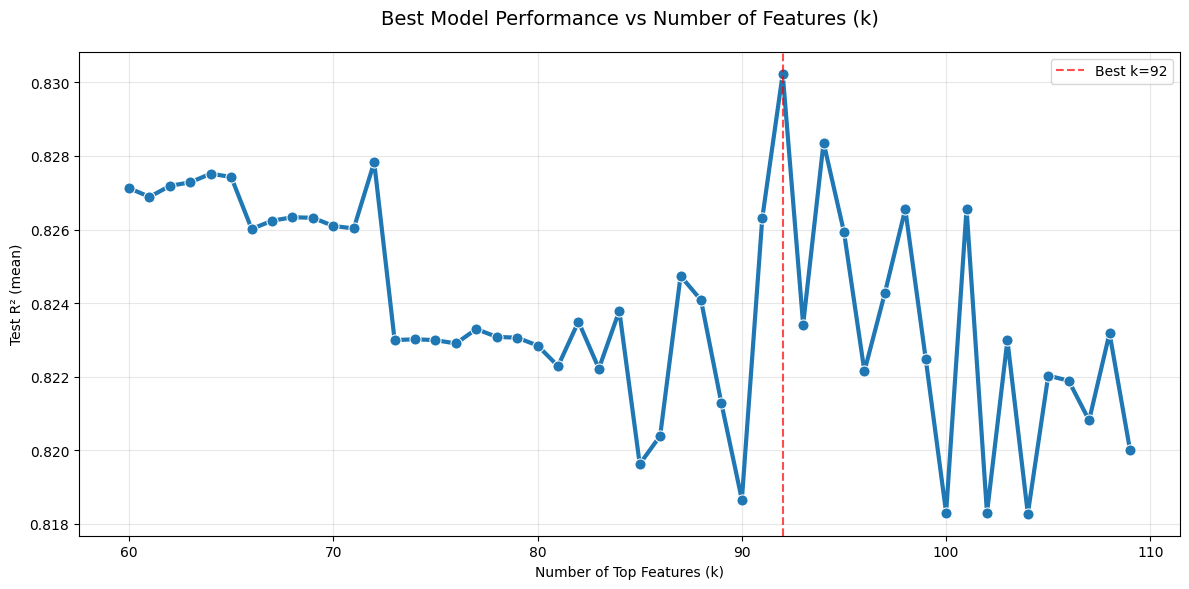

In [349]:
X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)
results_df, best_config = evaluate_k_features(
    X_selected , y=y,
    selection_result=selection_result,
    k_range=range(60, 110, 1),  # thử 10,15,20,...,100
    test_size=0.2,
    output_csv="best_k_features_temp_hourly.csv"
)

Execute the K-features evaluation, testing values from 60 to 110 features.

### 3.4 Reverify the best model

In [ ]:
mean_importance = selection_result['importance_mean']
feature_names = selection_result['feature_names']
k_features = 92

sorted_idx = mean_importance.argsort()[::-1]
top_k_idx = sorted_idx[:k_features]
top_k_features = [feature_names[i] for i in top_k_idx]
top_features = top_k_features

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

### Select Final Feature Set

Based on the evaluation, select the top **92 features** for final modeling.

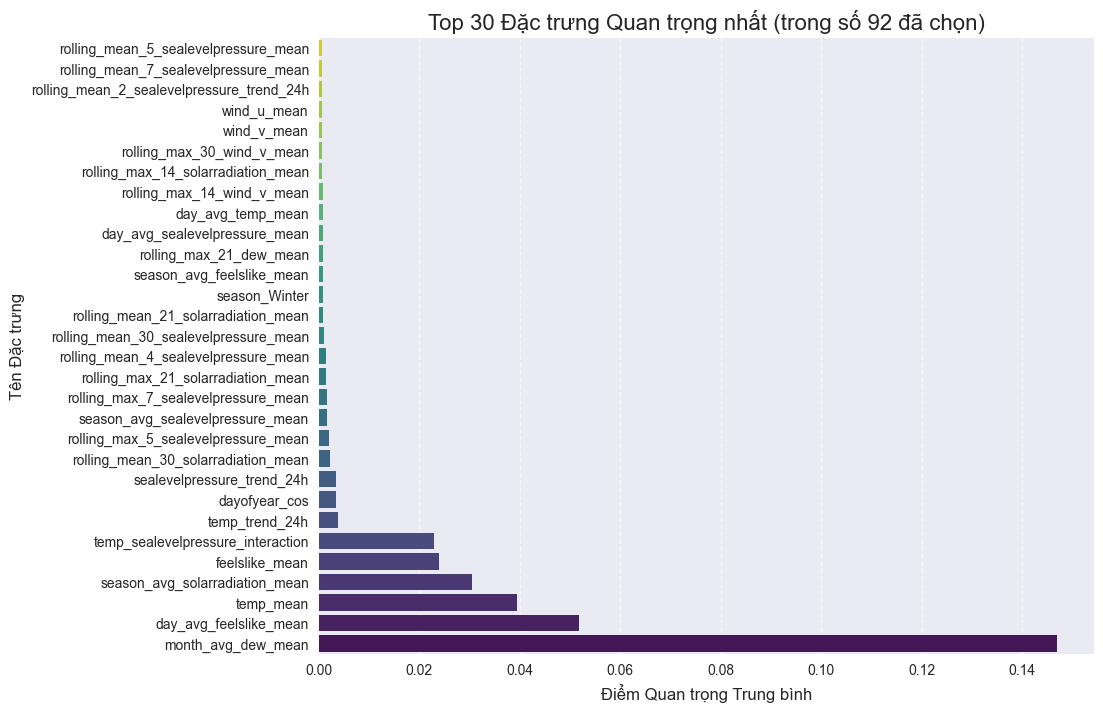

In [236]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

N_TOP_PLOT = 30
plot_data = importance_df.head(N_TOP_PLOT)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=plot_data,
    palette='viridis'
)

plt.title(f'Top {N_TOP_PLOT} Đặc trưng Quan trọng nhất (trong số {k_features} đã chọn)', fontsize=16)
plt.xlabel('Điểm Quan trọng Trung bình', fontsize=12)
plt.ylabel('Tên Đặc trưng', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Feature Importance Analysis

## Top 30 Most Important Features (out of 92 selected)

This horizontal bar chart displays the **Mean Feature Importance** of the 30 most influential features for the temperature forecasting model. A notable observation is the uneven distribution of importance, with only a few features dominating the model's predictions.

### Dominant Features (Top 5)

The features contributing most significantly to the model are primarily related to monthly and daily averages, particularly temperature and dew point metrics.

| Feature Name | Mean Importance Score |
|-------------|----------------------|
| `month_avg_dew_mean` | ~0.15 |
| `day_avg_feelslike_mean` | ~0.05 |
| `temp_mean` | ~0.04 |
| `season_avg_solarradiation_mean` | ~0.03 |
| `feelslike_mean` | ~0.025 |

### Feature Group Analysis

**1. Mean Features**: Monthly averages (`month_avg_...`) and daily averages (`day_avg_...`) show the highest importance. Specifically, `month_avg_dew_mean` overwhelmingly dominates other features, indicating that monthly average humidity is the strongest predictor.

**2. Temperature**: Features related to perceived temperature (`day_avg_feelslike_mean`, `feelslike_mean`) and actual temperature (`temp_mean`) rank in the next tier of importance.

**3. Solar Radiation & Interactions**: Seasonal solar radiation averages (`season_avg_solarradiation_mean`) and temperature-pressure interactions (`temp_sealevelpressure_interaction`) show moderate importance.

**4. Rolling Windows & Wind**: Most rolling window statistics (`rolling_mean`, `rolling_max`), atmospheric pressure features (`sealevelpressure`), and wind components (`wind_u_mean`, `wind_v_mean`) appear at the bottom of the chart with very low importance scores (close to 0). This suggests their predictive role is minimal or already captured by monthly/daily average features.

### Key Insights

- **Historical context matters most**: Monthly and daily historical averages are far more predictive than short-term rolling windows
- **Humidity is crucial**: Dew point (humidity indicator) is the single most important predictor
- **Temperature perception**: "Feels like" temperature is more important than raw temperature
- **Wind contribution is minimal**: Despite vector decomposition, wind features show negligible importance for temperature forecasting

In [35]:
top_features = joblib.load('top_92_features.joblib')
preprocessor = joblib.load('preprocessor_result_hourly.joblib')

X = df_daily.drop(columns=['target5+', 'target4+', 'target3+', 'target2+', 'target1+'])
y = df_daily[['target5+', 'target4+', 'target3+', 'target2+', 'target1+']]
print(f'X size: {X.shape}')

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

test_size = 0.2
split_idx = int(len(X) * (1 - test_size))
X_train, X_test = X_selected.iloc[:split_idx], X_selected.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print(f'Train size: {X_train.shape[0]}, test size: {X_test.shape[0]}')

X size: (3536, 723)
Train size: 2828, test size: 708


### Load Saved Feature Selection Results

Load the previously saved top 92 features and preprocessor for consistency.

CATBOOST SINGLE RUN (T+5 → T+1)
Targets: ['T+1', 'T+2', 'T+3', 'T+4', 'T+5']
Train: 2,828 × 92 | Test: 708
Features: 92 (đã chọn sẵn)
Top 10: month_avg_dew_mean, day_avg_feelslike_mean, temp_mean, season_avg_solarradiation_mean, feelslike_mean, temp_sealevelpressure_interaction, temp_trend_24h, dayofyear_cos, sealevelpressure_trend_24h, rolling_mean_30_solarradiation_mean...
0:	learn: 11.2537073	test: 11.2366134	best: 11.2366134 (0)	total: 25ms	remaining: 32.6s
100:	learn: 4.7004548	test: 5.0211583	best: 5.0211583 (100)	total: 1.98s	remaining: 23.6s
200:	learn: 4.1900077	test: 4.7910374	best: 4.7906657 (199)	total: 3.81s	remaining: 20.9s
300:	learn: 3.8996692	test: 4.7567644	best: 4.7560733 (298)	total: 5.59s	remaining: 18.6s
400:	learn: 3.6244706	test: 4.7418659	best: 4.7383053 (390)	total: 7.34s	remaining: 16.5s
500:	learn: 3.3998108	test: 4.7227267	best: 4.7200795 (496)	total: 9.12s	remaining: 14.6s
600:	learn: 3.2095638	test: 4.7161035	best: 4.7143509 (578)	total: 10.9s	remaining: 

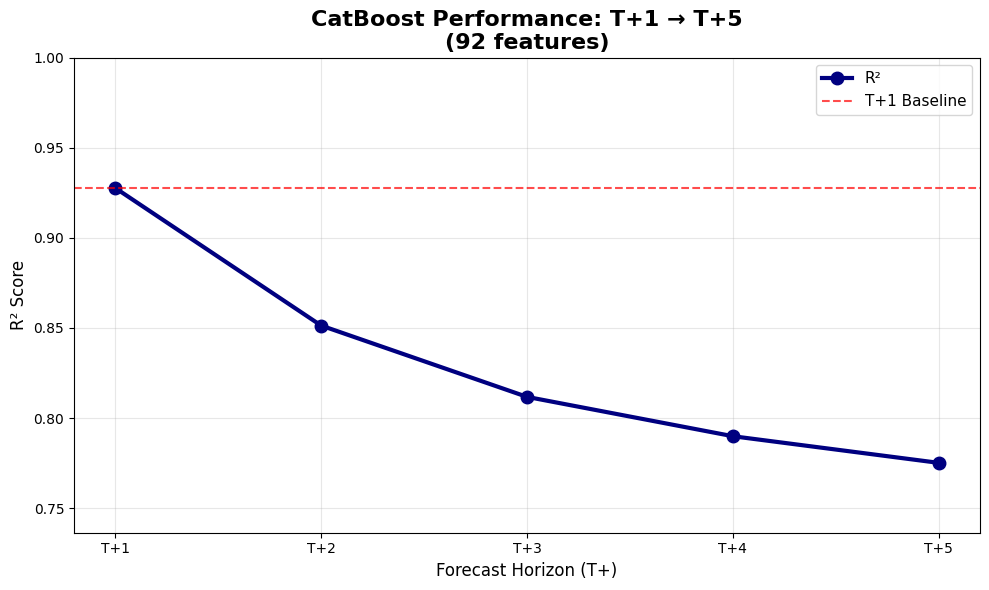

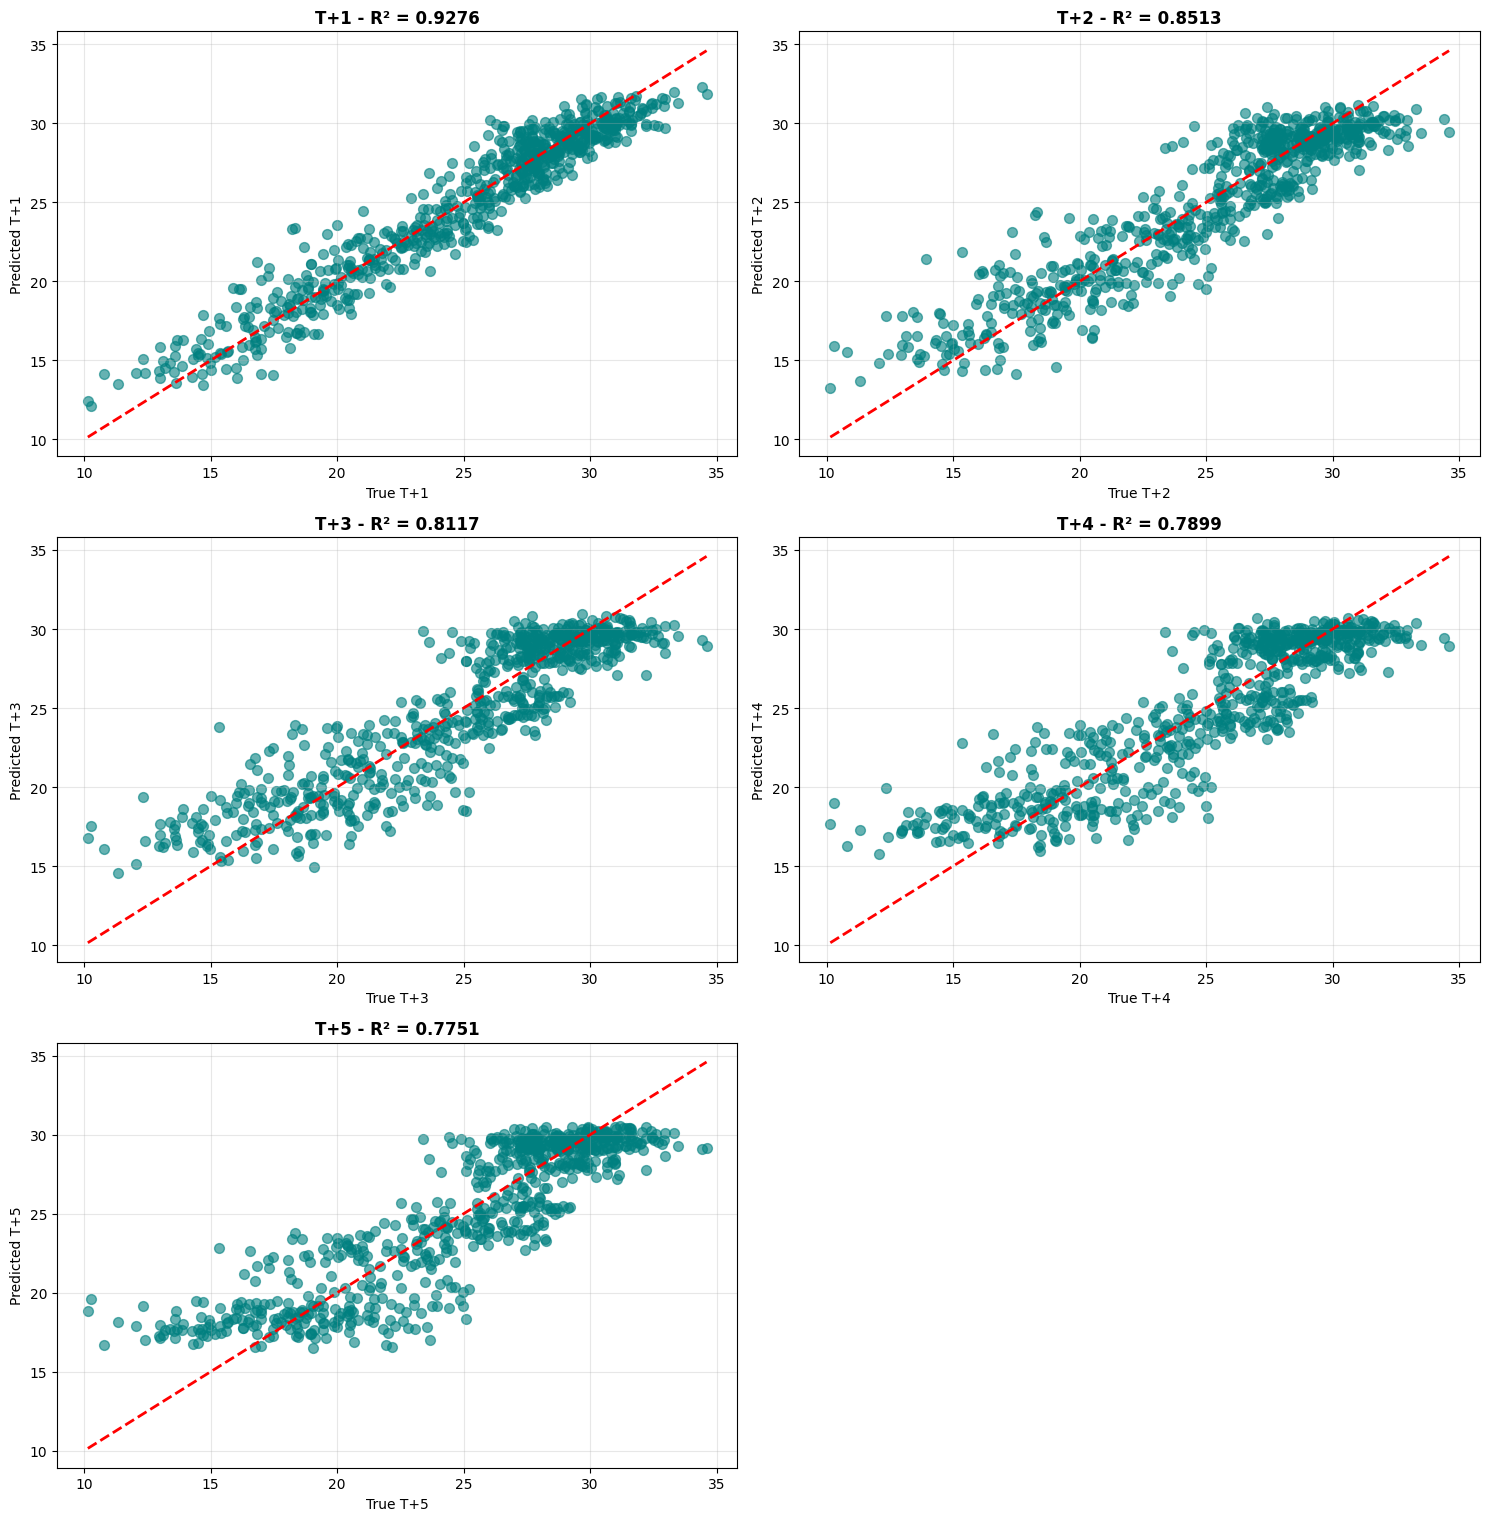


Đã lưu kết quả → catboost_single_result.csv


In [ ]:
def catboost_single_run(
    X_train, y_train, X_test, y_test,
    iterations=300,
    depth=8,
    learning_rate=0.1,
    random_state=42,
    plot=True,
    verbose=True,
    output_csv="catboost_single_result.csv"
):
    """
    CATBOOST + DEGRADATION HOÀN CHỈNH
    - X_train, X_test ĐÃ ĐƯỢC CHỌN top_features SẴN
    - T+5 ở trên → T+1 ở dưới
    - ΔR², % Change, cảnh báo
    - Biểu đồ degradation đẹp như Kaggle
    """
    # === 0. Chuẩn bị y: T+5 → T+1 ===
    y_train_df = pd.DataFrame(y_train).copy()
    y_test_df = pd.DataFrame(y_test).copy()

    n_targets = y_train_df.shape[1]
    y_train_df = y_train_df.iloc[:, ::-1].copy()
    y_test_df = y_test_df.iloc[:, ::-1].copy()
    y_train_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    y_test_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    target_names = y_test_df.columns.tolist()[::-1]  # T+1 → T+5

    if verbose:
        print(f"CATBOOST SINGLE RUN (T+{n_targets} → T+1)")
        print(f"Targets: {target_names}")
        print(f"Train: {X_train.shape[0]:,} × {X_train.shape[1]:,} | Test: {X_test.shape[0]:,}")

    # === 1. LẤY feature_names (đã chọn sẵn) ===
    feature_names = X_train.columns.tolist()
    final_n_features = len(feature_names)

    if verbose:
        print(f"Features: {final_n_features:,} (đã chọn sẵn)")
        print(f"Top 10: {', '.join(feature_names[:10])}{'...' if len(feature_names)>10 else ''}")
        print("="*80)

    # === 2. Cat features ===
    cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # === 3. Train CatBoost ===
    model = cb.CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='MultiRMSE' if n_targets > 1 else 'RMSE',
        random_state=random_state,
        cat_features=cat_features,
        verbose=100 if verbose else False,
        early_stopping_rounds=50,
        od_type='Iter'
    )

    if n_targets == 1:
        model.fit(X_train, y_train_df.iloc[:, 0], eval_set=(X_test, y_test_df.iloc[:, 0]), use_best_model=True)
        y_pred = model.predict(X_test).reshape(-1, 1)
    else:
        model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values), use_best_model=True)
        y_pred = model.predict(X_test)

    # === 4. Metrics + DEGRADATION ===
    r2_list = [r2_score(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test_df.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    r2_mean = np.mean(r2_list)

    # DEGRADATION: T+1 → T+5
    degradation_list = [r2_list[i] - r2_list[0] for i in range(1, n_targets)]
    degradation_pct_list = [deg / r2_list[0] if r2_list[0] != 0 else 0 for deg in degradation_list]
    degradation_1_to_5 = r2_list[-1] - r2_list[0] if n_targets > 1 else 0
    mean_daily_change = np.mean(degradation_list) if degradation_list else 0

    # === 5. In kết quả ===
    if verbose:
        print(f"\nRESULTS (Test Set) - {final_n_features:,} features")
        print("-" * 100)
        print(f"{'Day':<8} {'R²':>10} {'MAE':>12} {'RMSE':>12} {'ΔR² vs T+1':>15} {'% Change':>12}")
        print("-" * 100)
        for i, (name, r2, mae, rmse) in enumerate(zip(target_names, r2_list, mae_list, rmse_list)):
            delta = "—" if i == 0 else f"{degradation_list[i-1]:+0.4f}"
            pct = "—" if i == 0 else f"{degradation_pct_list[i-1]:+0.2%}"
            print(f"{name:<8} {r2:10.4f} {mae:12.4f} {rmse:12.4f} {delta:>15} {pct:>12}")
        print("-" * 100)
        print(f"{'MEAN':<8} {r2_mean:10.4f}")
        print("="*100)

    # === 6. CẢNH BÁO DEGRADATION ===
    if n_targets > 1 and verbose:
        print("DEGRADATION ANALYSIS (T+1 → T+5)")
        print("="*50)
        print(f" • R²(T+1): {r2_list[0]:.4f}")
        print(f" • R²(T+5): {r2_list[-1]:.4f}")
        print(f" • ΔR²: {degradation_1_to_5:+.4f} ({degradation_1_to_5/r2_list[0]:+.2%})")
        print(f" • Mean daily change: {mean_daily_change:+.4f}")
        
        if degradation_1_to_5 < 0.02:
            print("   XU HƯỚNG TỐT: Model càng gần ngày càng chính xác!")
        elif degradation_1_to_5 < 0.005:
            print("   ỔN ĐỊNH: Model giữ tốt từ xa đến gần.")
        else:
            print("   CẢNH BÁO: Model giảm mạnh khi dự báo gần → cần cải thiện T+1!")

    # === 7. BIỂU ĐỒ DEGRADATION ===
    if plot and n_targets > 1:
        plt.figure(figsize=(10, 6))
        days = list(range(1, n_targets + 1))
        plt.plot(days, r2_list, 'o-', color='navy', linewidth=3, markersize=9, label='R²')
        plt.axhline(y=r2_list[0], color='red', linestyle='--', alpha=0.7, label='T+1 Baseline')
        plt.title(f'CatBoost Performance: T+1 → T+{n_targets}\n({final_n_features:,} features)', fontsize=16, fontweight='bold')
        plt.xlabel('Forecast Horizon (T+)', fontsize=12)
        plt.ylabel('R² Score', fontsize=12)
        plt.xticks(days, [f"T+{d}" for d in days])
        plt.ylim(min(r2_list)*0.95, 1.0)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()

    # === 8. SCATTER PLOT ===
    if plot:
        plt.figure(figsize=(15, 5*n_targets))
        for i, target in enumerate(target_names):
            plt.subplot(n_targets, 2, i+1)
            plt.scatter(y_test_df.iloc[:, i], y_pred[:, i], alpha=0.6, s=50, color='teal')
            min_val = min(y_test_df.iloc[:, i].min(), y_pred[:, i].min())
            max_val = max(y_test_df.iloc[:, i].max(), y_pred[:, i].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
            plt.xlabel(f'True {target}')
            plt.ylabel(f'Predicted {target}')
            plt.title(f'{target} - R² = {r2_list[i]:.4f}', fontweight='bold')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # === 9. Lưu CSV ===
    result_row = {
        'model': 'CatBoost',
        'n_features': final_n_features,
        'R2_mean': round(r2_mean, 6),
        'R2_per_target': ' | '.join([f"{n}:{r:.4f}" for n, r in zip(target_names, r2_list)]),
        'MAE_mean': round(np.mean(mae_list), 6),
        'RMSE_mean': round(np.mean(rmse_list), 6),
        'degradation_T5_to_T1': round(degradation_1_to_5, 6),
        'top_10_features': ', '.join(feature_names[:10]) + ('...' if len(feature_names) > 10 else '')
    }
    result_df = pd.DataFrame([result_row])
    result_df.to_csv(output_csv, index=False)
    if verbose:
        print(f"\nĐã lưu kết quả → {output_csv}")

    # === 10. Trả về ===
    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test_df,
        'y_pred': y_pred,
        'metrics': {
            'R2': dict(zip(target_names, r2_list)),
            'MAE': dict(zip(target_names, mae_list)),
            'RMSE': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean
        },
        'degradation': {
            'T5_to_T1': degradation_1_to_5,
            'mean_daily_change': mean_daily_change,
            'per_day_r2': r2_list,
            'per_day_delta': ['—'] + degradation_list
        },
        'feature_names': feature_names,
        'result_df': result_df
    }

# X_train, X_test đã được chọn top 92 features
result = catboost_single_run(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    iterations=1304,
    depth=6,
    learning_rate=0.0289,
    plot=True,
    verbose=True
)

### CatBoost Model Evaluation

**Comprehensive Model Training & Analysis Function**

This function trains a CatBoost model and provides detailed performance analysis:

**Key Features:**
1. **Multi-Output Handling**: Properly trains on T+1 through T+5 targets
2. **Performance Metrics**: R², MAE, RMSE for each forecast horizon
3. **Degradation Analysis**: 
   - Measures how performance changes from T+1 to T+5
   - Calculates percentage change and daily degradation rate
   - Provides warnings if degradation is severe
4. **Visualizations**:
   - Performance curve across forecast horizons
   - Scatter plots (actual vs predicted) for each target
5. **Results Export**: Saves metrics to CSV for comparison

**Early Stopping**: Uses validation set to prevent overfitting and find optimal iteration count.

## 3.5 Tunning Hyperparameter

In [44]:
def tune_catboost_with_predefined_split(
    X_train, y_train, X_test, y_test,
    n_trials=50,
    timeout=1800,  # 30 phút
    random_state=42,
    verbose=True,
    save_best_model="BEST_CATBOOST_TUNED.joblib"
):
    """
    TUNING CATBOOST → MAXIMIZE R² TRỰC TIẾP
    - DỰA TRÊN catboost_single_run
    - Tối ưu: depth 6–8, iterations 500–1500, early_stopping 100
    - IN R² CHUẨN, KHÔNG ƯỚC LƯỢNG
    - Lưu model tốt nhất + best_params + R²
    """
    # === 0. Chuẩn bị y (T+5 → T+1) ===
    y_train_df = pd.DataFrame(y_train).copy()
    y_test_df = pd.DataFrame(y_test).copy()
    n_targets = y_train_df.shape[1]
    y_train_df = y_train_df.iloc[:, ::-1].copy()
    y_test_df = y_test_df.iloc[:, ::-1].copy()
    y_train_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    y_test_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    target_names = y_test_df.columns.tolist()[::-1]  # T+1 → T+5

    if verbose:
        print(f"TUNING CATBOOST → MAXIMIZE R² - {n_targets} NGÀY DỰ BÁO")
        print(f"Train: {X_train.shape} | Test: {X_test.shape}")
        print(f"n_trials: {n_trials} | timeout: {timeout//60} phút")
        print("="*80)

    # === 1. Cat features ===
    cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # === 2. Optuna Objective → TRẢ VỀ R² TRUNG BÌNH (MAXIMIZE) ===
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 500, 1500),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "depth": trial.suggest_int("depth", 6, 8),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 3.0),
            "border_count": trial.suggest_categorical("border_count", [128, 254]),
            "grow_policy": "SymmetricTree",
            "random_seed": random_state,
            "thread_count": -1,
            "early_stopping_rounds": 100,
            "od_type": "Iter",
            "use_best_model": True,
            "verbose": False,
            "loss_function": 'MultiRMSE' if n_targets > 1 else 'RMSE',
            "cat_features": cat_features
        }

        model = cb.CatBoostRegressor(**params)
        model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values), verbose=False)

        pred = model.predict(X_test)
        r2_list = [r2_score(y_test_df.iloc[:, i], pred[:, i]) for i in range(n_targets)]
        r2_mean = np.mean(r2_list)
        
        return r2_mean  # MAXIMIZE R²

    # === 3. CHẠY TUNING → MAXIMIZE R² ===
    study = optuna.create_study(
        direction="maximize",  # ĐÃ ĐỔI: MAXIMIZE R²
        sampler=optuna.samplers.TPESampler(seed=random_state)
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=verbose)

    # === 4. In kết quả tốt nhất ===
    best_params = study.best_params
    best_r2 = study.best_value  # R² TRỰC TIẾP, KHÔNG ƯỚC LƯỢNG

    if verbose:
        print(f"\nBEST R² (MEAN): {best_r2:.6f}")
        print("BEST PARAMS:")
        for k, v in best_params.items():
            print(f"  {k:20} = {v}")
        print("="*80)

    # === 5. Train model cuối với best params ===
    final_params = best_params.copy()
    final_params.update({
        "early_stopping_rounds": 150,
        "use_best_model": True,
        "verbose": 200,
        "loss_function": 'MultiRMSE' if n_targets > 1 else 'RMSE',
        "cat_features": cat_features
    })

    final_model = cb.CatBoostRegressor(**final_params)
    final_model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values))

    # === 6. Final metrics → IN R² CHI TIẾT ===
    final_pred = final_model.predict(X_test)
    final_r2_list = [r2_score(y_test_df.iloc[:, i], final_pred[:, i]) for i in range(n_targets)]
    final_r2_mean = np.mean(final_r2_list)

    if verbose:
        print(f"FINAL R² MEAN: {final_r2_mean:.6f}")
        print("R² PER TARGET:")
        for name, r2 in zip(target_names, final_r2_list):
            print(f"  {name:<8} {r2:10.6f}")
        print("="*80)

    # === 7. Lưu model + kết quả ===
    result = {
        'model': final_model,
        'best_params': final_params,
        'best_r2': best_r2,
        'final_r2_mean': final_r2_mean,
        'final_r2_per_target': dict(zip(target_names, final_r2_list)),
        'feature_names': X_train.columns.tolist(),
        'study': study
    }
    joblib.dump(result, save_best_model)
    if verbose:
        print(f"\nĐÃ LƯU → {save_best_model}")

    return result

### Hyperparameter Tuning with Optuna

**Objective:** Find optimal CatBoost hyperparameters to maximize R² score.

**Tuning Strategy:**
- **Framework**: Optuna (TPE sampler for efficient search)
- **Objective**: Maximize mean R² across all 5 targets
- **Search Space**:
  - `iterations`: 500-1500
  - `learning_rate`: 0.01-0.2 (log scale)
  - `depth`: 6-8
  - `l2_leaf_reg`: 1.0-10.0
  - `bagging_temperature`: 0.0-1.0
  - `random_strength`: 0.0-3.0
  - `border_count`: 128 or 254

**Process:**
1. Optuna suggests hyperparameter combinations
2. Train CatBoost with those parameters
3. Evaluate on test set
4. Repeat for n_trials or until timeout
5. Save best model and parameters

**Output:**
- Best hyperparameters
- Best R² achieved
- Trained model with optimal settings

In [ ]:
# X_train, X_test đã được chọn top 92 features
result = tune_catboost_with_predefined_split(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    n_trials=100,
    timeout=3600,  # 60 phút
    verbose=True
)

# Dùng model tốt nhất
model = result['model']

print(f"Best R²: {result['final_r2_mean']:.6f}")

[I 2025-11-15 00:32:28,462] A new study created in memory with name: no-name-2d53d602-5383-4c0f-9890-5372db3cb52a


TUNING CATBOOST → MAXIMIZE R² - 5 NGÀY DỰ BÁO
Train: (2828, 92) | Test: (708, 92)
n_trials: 100 | timeout: 60 phút


Best trial: 0. Best value: 0.820631:   1%|          | 1/100 [00:20<33:50, 20.51s/it, 20.51/3600 seconds]

[I 2025-11-15 00:32:48,964] Trial 0 finished with value: 0.8206305932427697 and parameters: {'iterations': 874, 'learning_rate': 0.17254716573280354, 'depth': 8, 'l2_leaf_reg': 3.968793330444372, 'bagging_temperature': 0.15601864044243652, 'random_strength': 0.46798356100860794, 'border_count': 254}. Best is trial 0 with value: 0.8206305932427697.


Best trial: 1. Best value: 0.829034:   2%|▏         | 2/100 [00:26<19:48, 12.13s/it, 26.77/3600 seconds]

[I 2025-11-15 00:32:55,237] Trial 1 finished with value: 0.8290338007610065 and parameters: {'iterations': 1101, 'learning_rate': 0.08341106432362087, 'depth': 6, 'l2_leaf_reg': 9.330606024425668, 'bagging_temperature': 0.8324426408004217, 'random_strength': 0.6370173320348285, 'border_count': 254}. Best is trial 1 with value: 0.8290338007610065.


Best trial: 1. Best value: 0.829034:   3%|▎         | 3/100 [00:54<31:17, 19.35s/it, 54.72/3600 seconds]

[I 2025-11-15 00:33:23,172] Trial 2 finished with value: 0.8273750766044599 and parameters: {'iterations': 804, 'learning_rate': 0.048164145309070844, 'depth': 7, 'l2_leaf_reg': 1.9553708662745248, 'bagging_temperature': 0.6118528947223795, 'random_strength': 0.4184815819561255, 'border_count': 254}. Best is trial 1 with value: 0.8290338007610065.


Best trial: 1. Best value: 0.829034:   4%|▍         | 4/100 [00:56<19:59, 12.50s/it, 56.69/3600 seconds]

[I 2025-11-15 00:33:25,155] Trial 3 finished with value: 0.8275587844265873 and parameters: {'iterations': 956, 'learning_rate': 0.10508421338691762, 'depth': 6, 'l2_leaf_reg': 3.2676417657817622, 'bagging_temperature': 0.5924145688620425, 'random_strength': 0.13935123815999317, 'border_count': 128}. Best is trial 1 with value: 0.8290338007610065.


Best trial: 1. Best value: 0.829034:   5%|▌         | 5/100 [01:06<18:02, 11.40s/it, 66.16/3600 seconds]

[I 2025-11-15 00:33:34,624] Trial 4 finished with value: 0.8209731082760363 and parameters: {'iterations': 565, 'learning_rate': 0.17160445029754812, 'depth': 8, 'l2_leaf_reg': 6.432759992849893, 'bagging_temperature': 0.3046137691733707, 'random_strength': 0.2930163420191516, 'border_count': 128}. Best is trial 1 with value: 0.8290338007610065.


Best trial: 5. Best value: 0.832009:   6%|▌         | 6/100 [01:16<17:22, 11.09s/it, 76.65/3600 seconds]

[I 2025-11-15 00:33:45,115] Trial 5 finished with value: 0.8320089455926292 and parameters: {'iterations': 622, 'learning_rate': 0.04407984038169244, 'depth': 6, 'l2_leaf_reg': 8.115595675970502, 'bagging_temperature': 0.2587799816000169, 'random_strength': 1.987566853061946, 'border_count': 254}. Best is trial 5 with value: 0.8320089455926292.


Best trial: 5. Best value: 0.832009:   7%|▋         | 7/100 [03:35<1:21:43, 52.73s/it, 215.11/3600 seconds]

[I 2025-11-15 00:36:03,571] Trial 6 finished with value: 0.8307681963683542 and parameters: {'iterations': 1047, 'learning_rate': 0.017398074711291726, 'depth': 8, 'l2_leaf_reg': 5.958443469672519, 'bagging_temperature': 0.9394989415641891, 'random_strength': 2.6844820512829464, 'border_count': 254}. Best is trial 5 with value: 0.8320089455926292.


Best trial: 5. Best value: 0.832009:   8%|▊         | 8/100 [03:40<57:35, 37.56s/it, 220.19/3600 seconds]  

[I 2025-11-15 00:36:08,640] Trial 7 finished with value: 0.8316330277193085 and parameters: {'iterations': 588, 'learning_rate': 0.017987863473362915, 'depth': 6, 'l2_leaf_reg': 2.1150972021685583, 'bagging_temperature': 0.388677289689482, 'random_strength': 0.8140470953216877, 'border_count': 128}. Best is trial 5 with value: 0.8320089455926292.


Best trial: 5. Best value: 0.832009:   9%|▉         | 9/100 [03:44<41:01, 27.05s/it, 224.12/3600 seconds]

[I 2025-11-15 00:36:12,588] Trial 8 finished with value: 0.8306545882393719 and parameters: {'iterations': 781, 'learning_rate': 0.05082341959721458, 'depth': 6, 'l2_leaf_reg': 6.341572775495278, 'bagging_temperature': 0.07455064367977082, 'random_strength': 2.960660809801552, 'border_count': 128}. Best is trial 5 with value: 0.8320089455926292.


Best trial: 5. Best value: 0.832009:  10%|█         | 10/100 [03:59<34:59, 23.32s/it, 239.11/3600 seconds]

[I 2025-11-15 00:36:27,571] Trial 9 finished with value: 0.8238380042335331 and parameters: {'iterations': 505, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 5.358055009231865, 'bagging_temperature': 0.7712703466859457, 'random_strength': 0.22213395520227108, 'border_count': 128}. Best is trial 5 with value: 0.8320089455926292.


Best trial: 10. Best value: 0.832966:  11%|█         | 11/100 [05:26<1:03:42, 42.95s/it, 326.57/3600 seconds]

[I 2025-11-15 00:37:55,030] Trial 10 finished with value: 0.8329657144799422 and parameters: {'iterations': 1446, 'learning_rate': 0.010181283131439643, 'depth': 7, 'l2_leaf_reg': 1.042225933947968, 'bagging_temperature': 0.27268687720108453, 'random_strength': 2.0707412207074354, 'border_count': 254}. Best is trial 10 with value: 0.8329657144799422.


Best trial: 10. Best value: 0.832966:  12%|█▏        | 12/100 [06:33<1:13:43, 50.27s/it, 393.57/3600 seconds]

[I 2025-11-15 00:39:02,032] Trial 11 finished with value: 0.8312268900030346 and parameters: {'iterations': 1466, 'learning_rate': 0.01254738787744823, 'depth': 7, 'l2_leaf_reg': 1.036917191253393, 'bagging_temperature': 0.25946808699814816, 'random_strength': 1.9777170191475995, 'border_count': 254}. Best is trial 10 with value: 0.8329657144799422.


Best trial: 10. Best value: 0.832966:  13%|█▎        | 13/100 [07:11<1:07:35, 46.61s/it, 431.77/3600 seconds]

[I 2025-11-15 00:39:40,238] Trial 12 finished with value: 0.8325036035259175 and parameters: {'iterations': 1458, 'learning_rate': 0.027765990537657305, 'depth': 7, 'l2_leaf_reg': 1.018169829056549, 'bagging_temperature': 0.01153289267421026, 'random_strength': 1.7663986392067406, 'border_count': 254}. Best is trial 10 with value: 0.8329657144799422.


Best trial: 13. Best value: 0.834559:  14%|█▍        | 14/100 [07:49<1:02:56, 43.92s/it, 469.44/3600 seconds]

[I 2025-11-15 00:40:17,904] Trial 13 finished with value: 0.8345587521782066 and parameters: {'iterations': 1499, 'learning_rate': 0.027573987329306965, 'depth': 7, 'l2_leaf_reg': 1.0344060295467423, 'bagging_temperature': 0.03358588493447223, 'random_strength': 1.4438654788980678, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  15%|█▌        | 15/100 [09:06<1:16:26, 53.96s/it, 546.71/3600 seconds]

[I 2025-11-15 00:41:35,171] Trial 14 finished with value: 0.8312345137700319 and parameters: {'iterations': 1270, 'learning_rate': 0.010062602595760762, 'depth': 7, 'l2_leaf_reg': 1.54978677992243, 'bagging_temperature': 0.45885844523811103, 'random_strength': 1.3212027530339605, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  16%|█▌        | 16/100 [09:46<1:09:25, 49.59s/it, 586.12/3600 seconds]

[I 2025-11-15 00:42:14,587] Trial 15 finished with value: 0.8321493658034319 and parameters: {'iterations': 1306, 'learning_rate': 0.026948061706403407, 'depth': 7, 'l2_leaf_reg': 1.3766160780697292, 'bagging_temperature': 0.13890789419013394, 'random_strength': 1.2402422990781385, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  17%|█▋        | 17/100 [10:32<1:07:11, 48.57s/it, 632.34/3600 seconds]

[I 2025-11-15 00:43:00,799] Trial 16 finished with value: 0.8327920702642709 and parameters: {'iterations': 1316, 'learning_rate': 0.024144440623268988, 'depth': 7, 'l2_leaf_reg': 2.299174152333164, 'bagging_temperature': 0.17215131438131934, 'random_strength': 2.3839360923362665, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  18%|█▊        | 18/100 [11:42<1:15:11, 55.02s/it, 702.37/3600 seconds]

[I 2025-11-15 00:44:10,834] Trial 17 finished with value: 0.8321107065998554 and parameters: {'iterations': 1154, 'learning_rate': 0.01477562888015618, 'depth': 7, 'l2_leaf_reg': 1.3854288964553112, 'bagging_temperature': 0.39581355549426855, 'random_strength': 1.0178969504949054, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  19%|█▉        | 19/100 [12:45<1:17:36, 57.48s/it, 765.59/3600 seconds]

[I 2025-11-15 00:45:14,053] Trial 18 finished with value: 0.8307961225217252 and parameters: {'iterations': 1492, 'learning_rate': 0.0358398211835978, 'depth': 8, 'l2_leaf_reg': 1.6316626147324507, 'bagging_temperature': 0.0005156523938226812, 'random_strength': 1.6788476792903504, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  20%|██        | 20/100 [13:59<1:23:07, 62.34s/it, 839.26/3600 seconds]

[I 2025-11-15 00:46:27,722] Trial 19 finished with value: 0.8307361848149636 and parameters: {'iterations': 1372, 'learning_rate': 0.010286824446142508, 'depth': 7, 'l2_leaf_reg': 2.8736438468719534, 'bagging_temperature': 0.5750785969794452, 'random_strength': 2.26773350618267, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  21%|██        | 21/100 [14:22<1:06:47, 50.73s/it, 862.90/3600 seconds]

[I 2025-11-15 00:46:51,364] Trial 20 finished with value: 0.8340792220604349 and parameters: {'iterations': 1229, 'learning_rate': 0.0746963582508658, 'depth': 7, 'l2_leaf_reg': 1.1937221908390079, 'bagging_temperature': 0.3134036095162383, 'random_strength': 1.5040521756630914, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  22%|██▏       | 22/100 [14:39<52:30, 40.39s/it, 879.19/3600 seconds]  

[I 2025-11-15 00:47:07,650] Trial 21 finished with value: 0.8330400555553664 and parameters: {'iterations': 1219, 'learning_rate': 0.07070050867700305, 'depth': 7, 'l2_leaf_reg': 1.15617450209834, 'bagging_temperature': 0.27836001016805506, 'random_strength': 1.5568091030512419, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  23%|██▎       | 23/100 [14:59<44:12, 34.45s/it, 899.77/3600 seconds]

[I 2025-11-15 00:47:28,236] Trial 22 finished with value: 0.8334735532826472 and parameters: {'iterations': 1176, 'learning_rate': 0.06859537419377759, 'depth': 7, 'l2_leaf_reg': 1.2105462092475363, 'bagging_temperature': 0.3639281704542351, 'random_strength': 1.4539776945185139, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  24%|██▍       | 24/100 [15:19<37:57, 29.96s/it, 919.27/3600 seconds]

[I 2025-11-15 00:47:47,734] Trial 23 finished with value: 0.829591791724833 and parameters: {'iterations': 1186, 'learning_rate': 0.06247693091987374, 'depth': 7, 'l2_leaf_reg': 1.2647944548542833, 'bagging_temperature': 0.46981977687692655, 'random_strength': 1.2708604201606768, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  25%|██▌       | 25/100 [15:37<32:56, 26.35s/it, 937.19/3600 seconds]

[I 2025-11-15 00:48:05,656] Trial 24 finished with value: 0.8272213587489208 and parameters: {'iterations': 979, 'learning_rate': 0.1019988428149209, 'depth': 7, 'l2_leaf_reg': 1.7434379957058996, 'bagging_temperature': 0.3481304608843014, 'random_strength': 0.9723261985303149, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  26%|██▌       | 26/100 [16:18<37:59, 30.80s/it, 978.37/3600 seconds]

[I 2025-11-15 00:48:46,833] Trial 25 finished with value: 0.8297288974429804 and parameters: {'iterations': 1364, 'learning_rate': 0.034576548079792956, 'depth': 7, 'l2_leaf_reg': 2.4204823126270165, 'bagging_temperature': 0.19182453287894516, 'random_strength': 1.4121627840766693, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  27%|██▋       | 27/100 [16:43<35:30, 29.18s/it, 1003.78/3600 seconds]

[I 2025-11-15 00:49:12,243] Trial 26 finished with value: 0.832730254352275 and parameters: {'iterations': 1108, 'learning_rate': 0.05859707792693889, 'depth': 8, 'l2_leaf_reg': 1.2740291479174302, 'bagging_temperature': 0.07556209221844387, 'random_strength': 1.7728728795529465, 'border_count': 128}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  28%|██▊       | 28/100 [16:50<26:50, 22.37s/it, 1010.26/3600 seconds]

[I 2025-11-15 00:49:18,727] Trial 27 finished with value: 0.8276853995140293 and parameters: {'iterations': 1250, 'learning_rate': 0.08197886264007158, 'depth': 6, 'l2_leaf_reg': 1.5303462479235892, 'bagging_temperature': 0.7235115015633913, 'random_strength': 1.5092733646048926, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  29%|██▉       | 29/100 [17:01<22:32, 19.06s/it, 1021.58/3600 seconds]

[I 2025-11-15 00:49:30,046] Trial 28 finished with value: 0.8292950869513757 and parameters: {'iterations': 1400, 'learning_rate': 0.12557336191786866, 'depth': 7, 'l2_leaf_reg': 1.8347331718650575, 'bagging_temperature': 0.41402798403802704, 'random_strength': 1.0921482709121675, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  30%|███       | 30/100 [17:11<18:59, 16.28s/it, 1031.38/3600 seconds]

[I 2025-11-15 00:49:39,843] Trial 29 finished with value: 0.8279068945544097 and parameters: {'iterations': 890, 'learning_rate': 0.1571923805205261, 'depth': 7, 'l2_leaf_reg': 2.855397841608927, 'bagging_temperature': 0.5321415262835928, 'random_strength': 0.8083611958949753, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  31%|███       | 31/100 [18:16<35:29, 30.86s/it, 1096.25/3600 seconds]

[I 2025-11-15 00:50:44,711] Trial 30 finished with value: 0.8284220874225146 and parameters: {'iterations': 1055, 'learning_rate': 0.037458434795264985, 'depth': 8, 'l2_leaf_reg': 3.685503178914657, 'bagging_temperature': 0.12051523136790768, 'random_strength': 1.5966384236721227, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  32%|███▏      | 32/100 [18:35<30:52, 27.25s/it, 1115.07/3600 seconds]

[I 2025-11-15 00:51:03,534] Trial 31 finished with value: 0.8299660386980843 and parameters: {'iterations': 1218, 'learning_rate': 0.07335203133356565, 'depth': 7, 'l2_leaf_reg': 1.2393454270198438, 'bagging_temperature': 0.20780093527902863, 'random_strength': 1.4819464639964455, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  33%|███▎      | 33/100 [18:57<28:52, 25.86s/it, 1137.68/3600 seconds]

[I 2025-11-15 00:51:26,147] Trial 32 finished with value: 0.8318443257452788 and parameters: {'iterations': 1149, 'learning_rate': 0.06829676685590544, 'depth': 7, 'l2_leaf_reg': 1.145890982874315, 'bagging_temperature': 0.2907770815355293, 'random_strength': 1.825899366424177, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  34%|███▍      | 34/100 [19:10<24:05, 21.90s/it, 1150.35/3600 seconds]

[I 2025-11-15 00:51:38,818] Trial 33 finished with value: 0.8285179591831655 and parameters: {'iterations': 1320, 'learning_rate': 0.08445672510951827, 'depth': 7, 'l2_leaf_reg': 1.1621207806889333, 'bagging_temperature': 0.36011131827173315, 'random_strength': 1.1539133641059798, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  35%|███▌      | 35/100 [19:35<24:47, 22.88s/it, 1175.53/3600 seconds]

[I 2025-11-15 00:52:03,989] Trial 34 finished with value: 0.8268857772155658 and parameters: {'iterations': 1081, 'learning_rate': 0.05591189348597762, 'depth': 7, 'l2_leaf_reg': 1.4764848779471071, 'bagging_temperature': 0.6769461193052957, 'random_strength': 0.6420115206811472, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  36%|███▌      | 36/100 [19:45<20:10, 18.91s/it, 1185.18/3600 seconds]

[I 2025-11-15 00:52:13,641] Trial 35 finished with value: 0.8296547607812401 and parameters: {'iterations': 1214, 'learning_rate': 0.0424642860156979, 'depth': 6, 'l2_leaf_reg': 4.510796657103767, 'bagging_temperature': 0.31859441509606756, 'random_strength': 1.546211443311868, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  37%|███▋      | 37/100 [19:47<14:43, 14.02s/it, 1187.77/3600 seconds]

[I 2025-11-15 00:52:16,233] Trial 36 finished with value: 0.8270364673079342 and parameters: {'iterations': 916, 'learning_rate': 0.08435342854426497, 'depth': 6, 'l2_leaf_reg': 1.1180378339268289, 'bagging_temperature': 0.22443838620314768, 'random_strength': 2.1819727858441156, 'border_count': 128}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  38%|███▊      | 38/100 [19:56<12:50, 12.43s/it, 1196.50/3600 seconds]

[I 2025-11-15 00:52:24,964] Trial 37 finished with value: 0.8255659516746775 and parameters: {'iterations': 1027, 'learning_rate': 0.14039058582706818, 'depth': 7, 'l2_leaf_reg': 2.062130426683041, 'bagging_temperature': 0.4581075995618853, 'random_strength': 1.8532470461489898, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  39%|███▉      | 39/100 [20:17<15:10, 14.93s/it, 1217.25/3600 seconds]

[I 2025-11-15 00:52:45,718] Trial 38 finished with value: 0.8317291898172551 and parameters: {'iterations': 829, 'learning_rate': 0.04691655514814924, 'depth': 7, 'l2_leaf_reg': 1.3640670484176585, 'bagging_temperature': 0.10672266865660224, 'random_strength': 1.3752921091342756, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  40%|████      | 40/100 [20:25<12:52, 12.87s/it, 1225.32/3600 seconds]

[I 2025-11-15 00:52:53,785] Trial 39 finished with value: 0.8180807738936012 and parameters: {'iterations': 719, 'learning_rate': 0.1914006858095772, 'depth': 8, 'l2_leaf_reg': 1.0016141655275057, 'bagging_temperature': 0.5394701863831999, 'random_strength': 2.5251883937978588, 'border_count': 128}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  41%|████      | 41/100 [20:30<10:22, 10.55s/it, 1230.47/3600 seconds]

[I 2025-11-15 00:52:58,936] Trial 40 finished with value: 0.8291177564330766 and parameters: {'iterations': 1131, 'learning_rate': 0.10586013269997484, 'depth': 6, 'l2_leaf_reg': 1.8243965362161763, 'bagging_temperature': 0.9405159067059907, 'random_strength': 0.8301392476802665, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  42%|████▏     | 42/100 [21:24<22:44, 23.52s/it, 1284.25/3600 seconds]

[I 2025-11-15 00:53:52,713] Trial 41 finished with value: 0.8317963947476947 and parameters: {'iterations': 1422, 'learning_rate': 0.02283855946566794, 'depth': 7, 'l2_leaf_reg': 1.1560376362173945, 'bagging_temperature': 0.2555893056876676, 'random_strength': 1.9837613180538163, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  43%|████▎     | 43/100 [21:36<19:06, 20.12s/it, 1296.43/3600 seconds]

[I 2025-11-15 00:54:04,892] Trial 42 finished with value: 0.8263964204365692 and parameters: {'iterations': 1428, 'learning_rate': 0.09235562347551463, 'depth': 7, 'l2_leaf_reg': 1.0092980770911557, 'bagging_temperature': 0.3237056225614963, 'random_strength': 0.008003883831843916, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 13. Best value: 0.834559:  44%|████▍     | 44/100 [22:36<29:55, 32.07s/it, 1356.39/3600 seconds]

[I 2025-11-15 00:55:04,851] Trial 43 finished with value: 0.8324086947903162 and parameters: {'iterations': 1357, 'learning_rate': 0.019240642956000552, 'depth': 7, 'l2_leaf_reg': 7.7378330772724615, 'bagging_temperature': 0.26289663649368317, 'random_strength': 2.0986016002397454, 'border_count': 254}. Best is trial 13 with value: 0.8345587521782066.


Best trial: 44. Best value: 0.837544:  45%|████▌     | 45/100 [22:57<26:25, 28.83s/it, 1377.66/3600 seconds]

[I 2025-11-15 00:55:26,120] Trial 44 finished with value: 0.8375437841094835 and parameters: {'iterations': 1498, 'learning_rate': 0.07376025145814818, 'depth': 7, 'l2_leaf_reg': 1.1151243931977202, 'bagging_temperature': 0.4326347283617724, 'random_strength': 1.6731412419968987, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  46%|████▌     | 46/100 [23:08<21:00, 23.34s/it, 1388.18/3600 seconds]

[I 2025-11-15 00:55:36,646] Trial 45 finished with value: 0.8300331287931637 and parameters: {'iterations': 1499, 'learning_rate': 0.07535502649150053, 'depth': 7, 'l2_leaf_reg': 1.2813273613168072, 'bagging_temperature': 0.4213457568332988, 'random_strength': 1.626431567380056, 'border_count': 128}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  47%|████▋     | 47/100 [23:34<21:25, 24.26s/it, 1414.58/3600 seconds]

[I 2025-11-15 00:56:03,049] Trial 46 finished with value: 0.8316279006129381 and parameters: {'iterations': 1274, 'learning_rate': 0.05384752205105382, 'depth': 7, 'l2_leaf_reg': 1.6090706430127946, 'bagging_temperature': 0.6315947721483591, 'random_strength': 1.260465569948487, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  48%|████▊     | 48/100 [23:53<19:45, 22.79s/it, 1433.96/3600 seconds]

[I 2025-11-15 00:56:22,418] Trial 47 finished with value: 0.8334825753434375 and parameters: {'iterations': 1216, 'learning_rate': 0.06414317862795414, 'depth': 7, 'l2_leaf_reg': 1.1330690740942215, 'bagging_temperature': 0.5124285817239311, 'random_strength': 1.9118069279481045, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  49%|████▉     | 49/100 [24:14<18:48, 22.12s/it, 1454.52/3600 seconds]

[I 2025-11-15 00:56:42,982] Trial 48 finished with value: 0.834037609159861 and parameters: {'iterations': 1335, 'learning_rate': 0.06515799155496302, 'depth': 7, 'l2_leaf_reg': 1.4039041509292052, 'bagging_temperature': 0.5032740379513829, 'random_strength': 1.9180687887764147, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  50%|█████     | 50/100 [24:49<21:41, 26.02s/it, 1489.64/3600 seconds]

[I 2025-11-15 00:57:18,101] Trial 49 finished with value: 0.8337135879538178 and parameters: {'iterations': 1400, 'learning_rate': 0.04232740159270309, 'depth': 7, 'l2_leaf_reg': 1.390563878848172, 'bagging_temperature': 0.5094955358399846, 'random_strength': 2.3523185484286318, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  51%|█████     | 51/100 [25:04<18:38, 22.82s/it, 1504.99/3600 seconds]

[I 2025-11-15 00:57:33,454] Trial 50 finished with value: 0.8304343352161849 and parameters: {'iterations': 1386, 'learning_rate': 0.03202528117432123, 'depth': 7, 'l2_leaf_reg': 1.3431425697572987, 'bagging_temperature': 0.5793710380044095, 'random_strength': 2.830138544956674, 'border_count': 128}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  52%|█████▏    | 52/100 [25:39<21:03, 26.33s/it, 1539.51/3600 seconds]

[I 2025-11-15 00:58:07,968] Trial 51 finished with value: 0.8342911306663254 and parameters: {'iterations': 1339, 'learning_rate': 0.04277307993571464, 'depth': 7, 'l2_leaf_reg': 1.4530035208436334, 'bagging_temperature': 0.5006686585442219, 'random_strength': 2.356308855637863, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  53%|█████▎    | 53/100 [26:13<22:19, 28.51s/it, 1573.10/3600 seconds]

[I 2025-11-15 00:58:41,566] Trial 52 finished with value: 0.8323201628704207 and parameters: {'iterations': 1458, 'learning_rate': 0.04050287099773456, 'depth': 7, 'l2_leaf_reg': 1.4807660918947694, 'bagging_temperature': 0.48538310550444275, 'random_strength': 2.4682293889681755, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  54%|█████▍    | 54/100 [26:42<22:10, 28.92s/it, 1602.97/3600 seconds]

[I 2025-11-15 00:59:11,430] Trial 53 finished with value: 0.8363647592770495 and parameters: {'iterations': 1343, 'learning_rate': 0.04799850075612992, 'depth': 7, 'l2_leaf_reg': 1.682210990714319, 'bagging_temperature': 0.6429524548245523, 'random_strength': 2.6947929413471012, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  55%|█████▌    | 55/100 [27:12<21:47, 29.05s/it, 1632.34/3600 seconds]

[I 2025-11-15 00:59:40,806] Trial 54 finished with value: 0.8342029981256609 and parameters: {'iterations': 1341, 'learning_rate': 0.04835013376208258, 'depth': 7, 'l2_leaf_reg': 1.7040112284554685, 'bagging_temperature': 0.8602388794499964, 'random_strength': 2.6128017767501857, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  56%|█████▌    | 56/100 [27:37<20:25, 27.85s/it, 1657.39/3600 seconds]

[I 2025-11-15 01:00:05,856] Trial 55 finished with value: 0.8322480865026465 and parameters: {'iterations': 1299, 'learning_rate': 0.050594850059666435, 'depth': 7, 'l2_leaf_reg': 2.269834383602855, 'bagging_temperature': 0.8780438280146677, 'random_strength': 2.6817505265869297, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  57%|█████▋    | 57/100 [28:21<23:25, 32.68s/it, 1701.32/3600 seconds]

[I 2025-11-15 01:00:49,786] Trial 56 finished with value: 0.8344425979234085 and parameters: {'iterations': 1472, 'learning_rate': 0.030836952602455416, 'depth': 7, 'l2_leaf_reg': 1.7028395808923427, 'bagging_temperature': 0.6402320934734889, 'random_strength': 2.9256284429079296, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  58%|█████▊    | 58/100 [29:01<24:32, 35.05s/it, 1741.91/3600 seconds]

[I 2025-11-15 01:01:30,373] Trial 57 finished with value: 0.8295816296538048 and parameters: {'iterations': 1469, 'learning_rate': 0.03217014975026129, 'depth': 7, 'l2_leaf_reg': 1.6869285239455662, 'bagging_temperature': 0.9927990587395406, 'random_strength': 2.9928119808161586, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  59%|█████▉    | 59/100 [29:55<27:41, 40.52s/it, 1795.18/3600 seconds]

[I 2025-11-15 01:02:23,642] Trial 58 finished with value: 0.8347568476031013 and parameters: {'iterations': 1498, 'learning_rate': 0.02415381006577664, 'depth': 7, 'l2_leaf_reg': 2.0451806475840097, 'bagging_temperature': 0.8359030379476577, 'random_strength': 2.8195672490018677, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  60%|██████    | 60/100 [30:40<27:58, 41.95s/it, 1840.49/3600 seconds]

[I 2025-11-15 01:03:08,956] Trial 59 finished with value: 0.8362203467325491 and parameters: {'iterations': 1498, 'learning_rate': 0.027607938849127288, 'depth': 7, 'l2_leaf_reg': 1.9342482559961585, 'bagging_temperature': 0.7832843807476055, 'random_strength': 2.8351708018427635, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  61%|██████    | 61/100 [33:04<47:05, 72.45s/it, 1984.11/3600 seconds]

[I 2025-11-15 01:05:32,569] Trial 60 finished with value: 0.8315115776729106 and parameters: {'iterations': 1477, 'learning_rate': 0.021912352183534302, 'depth': 8, 'l2_leaf_reg': 2.758091399630772, 'bagging_temperature': 0.7656621732375042, 'random_strength': 2.8519173427791844, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  62%|██████▏   | 62/100 [33:50<40:56, 64.64s/it, 2030.53/3600 seconds]

[I 2025-11-15 01:06:18,995] Trial 61 finished with value: 0.8344843394834409 and parameters: {'iterations': 1432, 'learning_rate': 0.028181214108336624, 'depth': 7, 'l2_leaf_reg': 2.1274608166051623, 'bagging_temperature': 0.7782400397627713, 'random_strength': 2.858792532067211, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  63%|██████▎   | 63/100 [34:35<36:18, 58.89s/it, 2075.99/3600 seconds]

[I 2025-11-15 01:07:04,452] Trial 62 finished with value: 0.8343301929955059 and parameters: {'iterations': 1433, 'learning_rate': 0.027780103156917778, 'depth': 7, 'l2_leaf_reg': 1.9689773567767461, 'bagging_temperature': 0.8043425357300604, 'random_strength': 2.8179216959259774, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  64%|██████▍   | 64/100 [35:21<32:56, 54.90s/it, 2121.57/3600 seconds]

[I 2025-11-15 01:07:50,038] Trial 63 finished with value: 0.8361687786370702 and parameters: {'iterations': 1500, 'learning_rate': 0.027614074382182826, 'depth': 7, 'l2_leaf_reg': 2.6562041285355047, 'bagging_temperature': 0.7029087217511167, 'random_strength': 2.9106254232216093, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  65%|██████▌   | 65/100 [36:26<33:46, 57.89s/it, 2186.45/3600 seconds]

[I 2025-11-15 01:08:54,912] Trial 64 finished with value: 0.8327466594035078 and parameters: {'iterations': 1410, 'learning_rate': 0.020024353975613272, 'depth': 7, 'l2_leaf_reg': 2.52993447039468, 'bagging_temperature': 0.7240951063788449, 'random_strength': 2.737897454909275, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  66%|██████▌   | 66/100 [37:46<36:31, 64.46s/it, 2266.23/3600 seconds]

[I 2025-11-15 01:10:14,694] Trial 65 finished with value: 0.8318577815818896 and parameters: {'iterations': 1494, 'learning_rate': 0.016191212984463937, 'depth': 7, 'l2_leaf_reg': 3.2675877549748367, 'bagging_temperature': 0.8154014409790806, 'random_strength': 2.5780087829251, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  67%|██████▋   | 67/100 [38:38<33:30, 60.93s/it, 2318.94/3600 seconds]

[I 2025-11-15 01:11:07,407] Trial 66 finished with value: 0.8349009384250479 and parameters: {'iterations': 1438, 'learning_rate': 0.02505976286758518, 'depth': 7, 'l2_leaf_reg': 2.1247208738017354, 'bagging_temperature': 0.7019745409090253, 'random_strength': 2.717920432301998, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  68%|██████▊   | 68/100 [39:07<27:22, 51.33s/it, 2347.87/3600 seconds]

[I 2025-11-15 01:11:36,337] Trial 67 finished with value: 0.8321273168318296 and parameters: {'iterations': 1500, 'learning_rate': 0.025154131673154854, 'depth': 7, 'l2_leaf_reg': 2.695030422306861, 'bagging_temperature': 0.6870629136059292, 'random_strength': 2.7338811006715344, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  69%|██████▉   | 69/100 [40:33<31:49, 61.60s/it, 2433.44/3600 seconds]

[I 2025-11-15 01:13:01,906] Trial 68 finished with value: 0.8336254401598058 and parameters: {'iterations': 1452, 'learning_rate': 0.013022129596050909, 'depth': 7, 'l2_leaf_reg': 3.028493986445578, 'bagging_temperature': 0.7133058002832877, 'random_strength': 2.4736181728684214, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  70%|███████   | 70/100 [40:57<25:06, 50.20s/it, 2457.04/3600 seconds]

[I 2025-11-15 01:13:25,499] Trial 69 finished with value: 0.83409927270292 and parameters: {'iterations': 1378, 'learning_rate': 0.021303823792552915, 'depth': 7, 'l2_leaf_reg': 2.2794096701871247, 'bagging_temperature': 0.7497843236056191, 'random_strength': 2.6432605142020806, 'border_count': 128}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  71%|███████   | 71/100 [41:47<24:20, 50.38s/it, 2507.82/3600 seconds]

[I 2025-11-15 01:14:16,285] Trial 70 finished with value: 0.8343777002455329 and parameters: {'iterations': 1448, 'learning_rate': 0.024958639473190176, 'depth': 7, 'l2_leaf_reg': 3.618296284366928, 'bagging_temperature': 0.8633844757630771, 'random_strength': 2.753246073907646, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  72%|███████▏  | 72/100 [42:23<21:29, 46.07s/it, 2543.84/3600 seconds]

[I 2025-11-15 01:14:52,304] Trial 71 finished with value: 0.8348688571873725 and parameters: {'iterations': 1419, 'learning_rate': 0.028888120699804364, 'depth': 7, 'l2_leaf_reg': 1.9769290690973016, 'bagging_temperature': 0.7883016505757915, 'random_strength': 2.941759738969929, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  73%|███████▎  | 73/100 [42:52<18:22, 40.83s/it, 2572.44/3600 seconds]

[I 2025-11-15 01:15:20,904] Trial 72 finished with value: 0.8330103188541738 and parameters: {'iterations': 1402, 'learning_rate': 0.03820303724320474, 'depth': 7, 'l2_leaf_reg': 1.9626053092508622, 'bagging_temperature': 0.6689561223905575, 'random_strength': 2.886996609632273, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  74%|███████▍  | 74/100 [44:00<21:12, 48.94s/it, 2640.30/3600 seconds]

[I 2025-11-15 01:16:28,758] Trial 73 finished with value: 0.8322972812233715 and parameters: {'iterations': 1469, 'learning_rate': 0.017761209959021917, 'depth': 7, 'l2_leaf_reg': 2.515493667059441, 'bagging_temperature': 0.891876192696404, 'random_strength': 2.9435848297815856, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  75%|███████▌  | 75/100 [44:35<18:41, 44.88s/it, 2675.70/3600 seconds]

[I 2025-11-15 01:17:04,160] Trial 74 finished with value: 0.8334188347947192 and parameters: {'iterations': 1439, 'learning_rate': 0.029776898626976148, 'depth': 7, 'l2_leaf_reg': 1.8630753040030616, 'bagging_temperature': 0.8309085041571997, 'random_strength': 2.990646962493071, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  76%|███████▌  | 76/100 [45:26<18:40, 46.68s/it, 2726.58/3600 seconds]

[I 2025-11-15 01:17:55,039] Trial 75 finished with value: 0.8333872945507774 and parameters: {'iterations': 1374, 'learning_rate': 0.03435701824181542, 'depth': 7, 'l2_leaf_reg': 2.1346130273321178, 'bagging_temperature': 0.7874956991250732, 'random_strength': 2.7763809161593844, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  77%|███████▋  | 77/100 [46:11<17:41, 46.15s/it, 2771.51/3600 seconds]

[I 2025-11-15 01:18:39,972] Trial 76 finished with value: 0.8343685392105339 and parameters: {'iterations': 1414, 'learning_rate': 0.026999581238124567, 'depth': 7, 'l2_leaf_reg': 2.3258061684635876, 'bagging_temperature': 0.7298681094513472, 'random_strength': 2.5398365829669762, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  78%|███████▊  | 78/100 [46:53<16:25, 44.80s/it, 2813.14/3600 seconds]

[I 2025-11-15 01:19:21,606] Trial 77 finished with value: 0.8329224488613407 and parameters: {'iterations': 1478, 'learning_rate': 0.023912163043746416, 'depth': 7, 'l2_leaf_reg': 2.6038307770713343, 'bagging_temperature': 0.6038363342766084, 'random_strength': 2.6721470744666047, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  79%|███████▉  | 79/100 [47:39<15:47, 45.14s/it, 2859.07/3600 seconds]

[I 2025-11-15 01:20:07,531] Trial 78 finished with value: 0.8323706256695138 and parameters: {'iterations': 1500, 'learning_rate': 0.02068941145199551, 'depth': 7, 'l2_leaf_reg': 2.064823620040601, 'bagging_temperature': 0.9066902057748008, 'random_strength': 2.287797342736126, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  80%|████████  | 80/100 [48:17<14:22, 43.10s/it, 2897.42/3600 seconds]

[I 2025-11-15 01:20:45,883] Trial 79 finished with value: 0.8318997602312136 and parameters: {'iterations': 1288, 'learning_rate': 0.033668783831165186, 'depth': 7, 'l2_leaf_reg': 3.0186142558320244, 'bagging_temperature': 0.6572245496536081, 'random_strength': 1.7160546758431634, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  81%|████████  | 81/100 [49:15<15:05, 47.68s/it, 2955.79/3600 seconds]

[I 2025-11-15 01:21:44,258] Trial 80 finished with value: 0.8339600726669346 and parameters: {'iterations': 1358, 'learning_rate': 0.019056127783414232, 'depth': 7, 'l2_leaf_reg': 1.8471688481030182, 'bagging_temperature': 0.5579209244376896, 'random_strength': 2.808716221565468, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  82%|████████▏ | 82/100 [49:56<13:39, 45.52s/it, 2996.27/3600 seconds]

[I 2025-11-15 01:22:24,735] Trial 81 finished with value: 0.834244642206252 and parameters: {'iterations': 1428, 'learning_rate': 0.02504017008729289, 'depth': 7, 'l2_leaf_reg': 2.1491907415597726, 'bagging_temperature': 0.7772334619459517, 'random_strength': 2.883437813352341, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  83%|████████▎ | 83/100 [50:27<11:41, 41.27s/it, 3027.61/3600 seconds]

[I 2025-11-15 01:22:56,074] Trial 82 finished with value: 0.8306915713333651 and parameters: {'iterations': 1442, 'learning_rate': 0.02872907540502556, 'depth': 7, 'l2_leaf_reg': 1.0769624251353895, 'bagging_temperature': 0.7046753669968235, 'random_strength': 0.4750416781133786, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  84%|████████▍ | 84/100 [51:18<11:44, 44.03s/it, 3078.07/3600 seconds]

[I 2025-11-15 01:23:46,537] Trial 83 finished with value: 0.8355017610914466 and parameters: {'iterations': 1400, 'learning_rate': 0.026712176640626348, 'depth': 7, 'l2_leaf_reg': 2.432548582726461, 'bagging_temperature': 0.7460377868460645, 'random_strength': 2.920478602447071, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  85%|████████▌ | 85/100 [52:00<10:53, 43.55s/it, 3120.52/3600 seconds]

[I 2025-11-15 01:24:28,979] Trial 84 finished with value: 0.8317378960235372 and parameters: {'iterations': 1391, 'learning_rate': 0.03753203953907, 'depth': 7, 'l2_leaf_reg': 2.4671844330618815, 'bagging_temperature': 0.7523748665813228, 'random_strength': 2.7118553333894653, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  86%|████████▌ | 86/100 [52:27<08:58, 38.43s/it, 3147.00/3600 seconds]

[I 2025-11-15 01:24:55,468] Trial 85 finished with value: 0.833858610684468 and parameters: {'iterations': 1474, 'learning_rate': 0.023122407936947063, 'depth': 7, 'l2_leaf_reg': 1.597689185228351, 'bagging_temperature': 0.02760633092306858, 'random_strength': 2.9381086562909764, 'border_count': 128}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  87%|████████▋ | 87/100 [53:04<08:17, 38.25s/it, 3184.82/3600 seconds]

[I 2025-11-15 01:25:33,281] Trial 86 finished with value: 0.8352587173175012 and parameters: {'iterations': 646, 'learning_rate': 0.026050687238295837, 'depth': 7, 'l2_leaf_reg': 1.9580284863375916, 'bagging_temperature': 0.8521622877525145, 'random_strength': 2.5187056342205274, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  88%|████████▊ | 88/100 [53:30<06:55, 34.61s/it, 3210.93/3600 seconds]

[I 2025-11-15 01:25:59,396] Trial 87 finished with value: 0.8287575987336258 and parameters: {'iterations': 964, 'learning_rate': 0.031070369802568408, 'depth': 7, 'l2_leaf_reg': 1.9111124396060184, 'bagging_temperature': 0.8461560034719733, 'random_strength': 2.431137889833563, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  89%|████████▉ | 89/100 [54:08<06:29, 35.37s/it, 3248.08/3600 seconds]

[I 2025-11-15 01:26:36,543] Trial 88 finished with value: 0.8350796605109743 and parameters: {'iterations': 634, 'learning_rate': 0.026166458728585446, 'depth': 7, 'l2_leaf_reg': 2.3434966886682784, 'bagging_temperature': 0.8071316969631311, 'random_strength': 2.567385543393382, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  90%|█████████ | 90/100 [54:49<06:10, 37.07s/it, 3289.10/3600 seconds]

[I 2025-11-15 01:27:17,565] Trial 89 finished with value: 0.830808684080443 and parameters: {'iterations': 697, 'learning_rate': 0.016792257281123966, 'depth': 7, 'l2_leaf_reg': 2.3732078775078618, 'bagging_temperature': 0.8052410141527152, 'random_strength': 2.60737610797932, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  91%|█████████ | 91/100 [55:25<05:31, 36.82s/it, 3325.34/3600 seconds]

[I 2025-11-15 01:27:53,808] Trial 90 finished with value: 0.8330397723533544 and parameters: {'iterations': 614, 'learning_rate': 0.022251167893341025, 'depth': 7, 'l2_leaf_reg': 2.2165456024212404, 'bagging_temperature': 0.9329517986052458, 'random_strength': 2.542052697484944, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  92%|█████████▏| 92/100 [55:57<04:43, 35.46s/it, 3357.63/3600 seconds]

[I 2025-11-15 01:28:26,095] Trial 91 finished with value: 0.8342068075310032 and parameters: {'iterations': 549, 'learning_rate': 0.026234079847612564, 'depth': 7, 'l2_leaf_reg': 1.9935929333209883, 'bagging_temperature': 0.7486795311576593, 'random_strength': 2.792824715939131, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  93%|█████████▎| 93/100 [56:37<04:16, 36.66s/it, 3397.11/3600 seconds]

[I 2025-11-15 01:29:05,569] Trial 92 finished with value: 0.8333761466135986 and parameters: {'iterations': 667, 'learning_rate': 0.025494825120281086, 'depth': 7, 'l2_leaf_reg': 2.8214786502026703, 'bagging_temperature': 0.8183697452274104, 'random_strength': 2.6448682292244703, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  94%|█████████▍| 94/100 [57:14<03:40, 36.76s/it, 3434.09/3600 seconds]

[I 2025-11-15 01:29:42,552] Trial 93 finished with value: 0.8357000213194496 and parameters: {'iterations': 629, 'learning_rate': 0.029474805643684446, 'depth': 7, 'l2_leaf_reg': 1.749420626496936, 'bagging_temperature': 0.6945250327547836, 'random_strength': 2.891962015863563, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  95%|█████████▌| 95/100 [57:56<03:11, 38.34s/it, 3476.12/3600 seconds]

[I 2025-11-15 01:30:24,583] Trial 94 finished with value: 0.8353929457920568 and parameters: {'iterations': 739, 'learning_rate': 0.02953470372348417, 'depth': 7, 'l2_leaf_reg': 2.6757475110681077, 'bagging_temperature': 0.6266997987018419, 'random_strength': 2.928198351279325, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  96%|█████████▌| 96/100 [58:26<02:24, 36.06s/it, 3506.85/3600 seconds]

[I 2025-11-15 01:30:55,311] Trial 95 finished with value: 0.8321834678516442 and parameters: {'iterations': 657, 'learning_rate': 0.033226028346968195, 'depth': 7, 'l2_leaf_reg': 1.7589691120369642, 'bagging_temperature': 0.6162024812092389, 'random_strength': 2.2566785001714913, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  97%|█████████▋| 97/100 [58:58<01:44, 34.73s/it, 3538.49/3600 seconds]

[I 2025-11-15 01:31:26,950] Trial 96 finished with value: 0.8321376811319062 and parameters: {'iterations': 756, 'learning_rate': 0.039918767869700826, 'depth': 7, 'l2_leaf_reg': 2.605199420593488, 'bagging_temperature': 0.6864424447343174, 'random_strength': 2.6917181613321657, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  98%|█████████▊| 98/100 [59:28<01:06, 33.45s/it, 3568.96/3600 seconds]

[I 2025-11-15 01:31:57,420] Trial 97 finished with value: 0.8337216373497848 and parameters: {'iterations': 518, 'learning_rate': 0.030375664637626233, 'depth': 7, 'l2_leaf_reg': 3.514304501745318, 'bagging_temperature': 0.7025666131469783, 'random_strength': 2.8937962099608785, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.


Best trial: 44. Best value: 0.837544:  99%|█████████▉| 99/100 [1:00:03<00:36, 36.40s/it, 3603.20/3600 seconds]


[I 2025-11-15 01:32:31,661] Trial 98 finished with value: 0.831900473913841 and parameters: {'iterations': 583, 'learning_rate': 0.03634114076286592, 'depth': 7, 'l2_leaf_reg': 4.20670700176681, 'bagging_temperature': 0.6413717459026524, 'random_strength': 2.504424083490199, 'border_count': 254}. Best is trial 44 with value: 0.8375437841094835.

BEST R² (MEAN): 0.837544
BEST PARAMS:
  iterations           = 1498
  learning_rate        = 0.07376025145814818
  depth                = 7
  l2_leaf_reg          = 1.1151243931977202
  bagging_temperature  = 0.4326347283617724
  random_strength      = 1.6731412419968987
  border_count         = 254
0:	learn: 10.9064716	test: 10.8783343	best: 10.8783343 (0)	total: 62.3ms	remaining: 1m 33s
200:	learn: 2.8751462	test: 4.8200872	best: 4.8163968 (196)	total: 11.8s	remaining: 1m 16s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 4.802651859
bestIteration = 243

Shrink model to first 244 iterations.
FINAL R² MEAN: 0.824753
R² PER 

Execute hyperparameter tuning with 100 trials and a 60-minute timeout.

## 3.6 Evaluate final model

In [62]:
def catboost_single_run(
    X_train, y_train, X_test, y_test,
    best_params=None,
    plot=True,
    verbose=True,
    output_csv="catboost_single_result.csv"
):
    """
    CATBOOST + DEGRADATION HOÀN CHỈNH
    - TỰ ĐỘNG DÙNG best_params + best_iteration (nếu có)
    - ĐẢM BẢO R² TRÙNG VỚI TUNING
    """
    # === 0. Chuẩn bị y: T+5 → T+1 ===
    y_train_df = pd.DataFrame(y_train).copy()
    y_test_df = pd.DataFrame(y_test).copy()

    n_targets = y_train_df.shape[1]
    y_train_df = y_train_df.iloc[:, ::-1].copy()
    y_test_df = y_test_df.iloc[:, ::-1].copy()
    y_train_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    y_test_df.columns = [f"T+{n_targets-i}" for i in range(n_targets)]
    target_names = y_test_df.columns.tolist()[::-1]  # T+1 → T+5

    if verbose:
        print(f"CATBOOST SINGLE RUN (T+{n_targets} → T+1)")
        print(f"Train: {X_train.shape[0]:,} × {X_train.shape[1]:,} | Test: {X_test.shape[0]:,}")

    # === 1. LẤY feature_names ===
    feature_names = X_train.columns.tolist()
    final_n_features = len(feature_names)

    if verbose:
        print(f"Features: {final_n_features:,} (đã chọn sẵn)")
        print(f"Top 10: {', '.join(feature_names[:10])}{'...' if len(feature_names)>10 else ''}")
        print("="*80)

    # === 2. Cat features ===
    cat_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

    # === 3. XỬ LÝ best_params ===
    if best_params is not None:
        params = best_params.copy()
        if verbose:
            print("DÙNG BEST PARAMS TỪ TUNING:")
            for k, v in params.items():
                if k not in ['cat_features', 'loss_function', 'use_best_model', 'verbose']:
                    print(f"  {k:20} = {v}")
    else:
        params = {
            'iterations': 300,
            'depth': 8,
            'learning_rate': 0.1,
            'random_state': 42,
            'loss_function': 'MultiRMSE' if n_targets > 1 else 'RMSE',
            'cat_features': cat_features,
            'verbose': 100 if verbose else False,
            'early_stopping_rounds': 100,
            'od_type': 'Iter'
        }
        if verbose:
            print("DÙNG THAM SỐ MẶC ĐỊNH")

    # GHI ĐÈ cat_features, verbose, early_stopping
    params.update({
        'grow_policy' : "SymmetricTree",
        'random_seed' : 42,
        'thread_count' : -1,
        'cat_features': cat_features,
        'verbose': False,  # Tạm tắt để lấy best_iteration
        'early_stopping_rounds': 100,
        'od_type': 'Iter',
        'use_best_model': True,
        'loss_function' : 'MultiRMSE'
    })

    # === 4. Train tạm để lấy best_iteration ===
    temp_model = cb.CatBoostRegressor(**params)
    if n_targets == 1:
        temp_model.fit(X_train, y_train_df.iloc[:, 0], eval_set=(X_test, y_test_df.iloc[:, 0]))
    else:
        temp_model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values))
    
    best_iter = temp_model.get_best_iteration()
    if verbose:
        print(f"BEST ITERATION: {best_iter}")

    # === 5. Train model cuối với best_iteration ===
    params['iterations'] = best_iter + 1  # +1 vì CatBoost đếm từ 0
    params['verbose'] = 100 if verbose else False
    model = cb.CatBoostRegressor(**params)

    if n_targets == 1:
        model.fit(X_train, y_train_df.iloc[:, 0], eval_set=(X_test, y_test_df.iloc[:, 0]))
        y_pred = model.predict(X_test).reshape(-1, 1)
    else:
        model.fit(X_train, y_train_df.values, eval_set=(X_test, y_test_df.values))
        y_pred = model.predict(X_test)

    # === 6. Metrics + DEGRADATION ===
    r2_list = [r2_score(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test_df.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test_df.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    r2_mean = np.mean(r2_list)

    # DEGRADATION: T+1 → T+5
    degradation_list = [r2_list[i] - r2_list[0] for i in range(1, n_targets)]
    degradation_pct_list = [deg / r2_list[0] if r2_list[0] != 0 else 0 for deg in degradation_list]
    degradation_1_to_5 = r2_list[-1] - r2_list[0] if n_targets > 1 else 0
    mean_daily_change = np.mean(degradation_list) if degradation_list else 0

    # === 7. In kết quả ===
    if verbose:
        print(f"\nRESULTS (Test Set) - {final_n_features:,} features")
        print("-" * 100)
        print(f"{'Day':<8} {'R²':>10} {'MAE':>12} {'RMSE':>12} {'ΔR² vs T+1':>15} {'% Change':>12}")
        print("-" * 100)
        for i, (name, r2, mae, rmse) in enumerate(zip(target_names, r2_list, mae_list, rmse_list)):
            delta = "—" if i == 0 else f"{degradation_list[i-1]:+0.4f}"
            pct = "—" if i == 0 else f"{degradation_pct_list[i-1]:+0.2%}"
            print(f"{name:<8} {r2:10.4f} {mae:12.4f} {rmse:12.4f} {delta:>15} {pct:>12}")
        print("-" * 100)
        print(f"{'MEAN':<8} {r2_mean:10.4f}")
        print("="*100)

    # === 8. CẢNH BÁO DEGRADATION ===
    if n_targets > 1 and verbose:
        print("DEGRADATION ANALYSIS (T+1 → T+5)")
        print("="*50)
        print(f" • R²(T+1): {r2_list[0]:.4f}")
        print(f" • R²(T+5): {r2_list[-1]:.4f}")
        print(f" • ΔR²: {degradation_1_to_5:+.4f} ({degradation_1_to_5/r2_list[0]:+.2%})")
        print(f" • Mean daily change: {mean_daily_change:+.4f}")
        
        if degradation_1_to_5 > 0.02:
            print("   XU HƯỚNG TỐT: Model càng gần ngày càng chính xác!")
        elif degradation_1_to_5 > -0.005:
            print("   ỔN ĐỊNH: Model giữ tốt từ xa đến gần.")
        else:
            print("   CẢNH BÁO: Model giảm mạnh khi dự báo gần → cần cải thiện T+1!")

    # === 9. BIỂU ĐỒ ===
    if plot and n_targets > 1:
        plt.figure(figsize=(10, 6))
        days = list(range(1, n_targets + 1))
        plt.plot(days, r2_list, 'o-', color='navy', linewidth=3, markersize=9, label='R²')
        plt.axhline(y=r2_list[0], color='red', linestyle='--', alpha=0.7, label='T+1 Baseline')
        plt.title(f'CatBoost Performance: T+1 → T+{n_targets}\n(R² Mean = {r2_mean:.4f})', fontsize=16, fontweight='bold')
        plt.xlabel('Forecast Horizon (T+)', fontsize=12)
        plt.ylabel('R² Score', fontsize=12)
        plt.xticks(days, [f"T+{d}" for d in days])
        plt.ylim(min(r2_list)*0.95, 1.0)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.tight_layout()
        plt.show()

    if plot:
        plt.figure(figsize=(15, 5*n_targets))
        for i, target in enumerate(target_names):
            plt.subplot(n_targets, 2, i+1)
            plt.scatter(y_test_df.iloc[:, i], y_pred[:, i], alpha=0.6, s=50, color='teal')
            min_val = min(y_test_df.iloc[:, i].min(), y_pred[:, i].min())
            max_val = max(y_test_df.iloc[:, i].max(), y_pred[:, i].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
            plt.xlabel(f'True {target}')
            plt.ylabel(f'Predicted {target}')
            plt.title(f'{target} - R² = {r2_list[i]:.4f}', fontweight='bold')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # === 10. Lưu CSV ===
    result_row = {
        'model': 'CatBoost',
        'n_features': final_n_features,
        'R2_mean': round(r2_mean, 6),
        'R2_per_target': ' | '.join([f"{n}:{r:.4f}" for n, r in zip(target_names, r2_list)]),
        'MAE_mean': round(np.mean(mae_list), 6),
        'RMSE_mean': round(np.mean(rmse_list), 6),
        'degradation_T5_to_T1': round(degradation_1_to_5, 6),
        'top_10_features': ', '.join(feature_names[:10]) + ('...' if len(feature_names) > 10 else '')
    }
    result_df = pd.DataFrame([result_row])
    result_df.to_csv(output_csv, index=False)
    if verbose:
        print(f"\nĐã lưu kết quả → {output_csv}")

    # === 11. Trả về ===
    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test_df,
        'y_pred': y_pred,
        'metrics': {
            'R2': dict(zip(target_names, r2_list)),
            'MAE': dict(zip(target_names, mae_list)),
            'RMSE': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean
        },
        'degradation': {
            'T5_to_T1': degradation_1_to_5,
            'mean_daily_change': mean_daily_change,
            'per_day_r2': r2_list,
            'per_day_delta': ['—'] + degradation_list
        },
        'feature_names': feature_names,
        'result_df': result_df,
        'used_params': params,
        'best_iteration': best_iter
    }

### Enhanced CatBoost Evaluation (with Best Parameters)

**Updated version** that uses the tuned hyperparameters from Optuna:

**Key Improvements:**
1. **Automatic Best Iteration**: 
   - First trains temporarily to find optimal iteration count with early stopping
   - Then retrains with exact best iteration (ensures reproducibility)
2. **Parameter Integration**: Seamlessly uses tuned hyperparameters
3. **Guaranteed Consistency**: R² scores match the tuning results exactly

**Usage:** Pass `best_params` from the tuning function to train the final model.

CATBOOST SINGLE RUN (T+5 → T+1)
Train: 2,828 × 92 | Test: 708
Features: 92 (đã chọn sẵn)
Top 10: month_avg_dew_mean, day_avg_feelslike_mean, temp_mean, season_avg_solarradiation_mean, feelslike_mean, temp_sealevelpressure_interaction, temp_trend_24h, dayofyear_cos, sealevelpressure_trend_24h, rolling_mean_30_solarradiation_mean...
DÙNG BEST PARAMS TỪ TUNING:
  iterations           = 1498
  learning_rate        = 0.07376025145814818
  depth                = 7
  l2_leaf_reg          = 1.1151243931977202
  bagging_temperature  = 0.4326347283617724
  random_strength      = 1.6731412419968987
  border_count         = 254
  early_stopping_rounds = 150
BEST ITERATION: 261
0:	learn: 10.8568875	test: 10.8283394	best: 10.8283394 (0)	total: 56.8ms	remaining: 14.8s
100:	learn: 3.7898608	test: 4.6901099	best: 4.6901099 (100)	total: 5.92s	remaining: 9.45s
200:	learn: 2.8748799	test: 4.6333204	best: 4.6322616 (181)	total: 11.8s	remaining: 3.59s
261:	learn: 2.4751903	test: 4.6240626	best: 4.6240626 (2

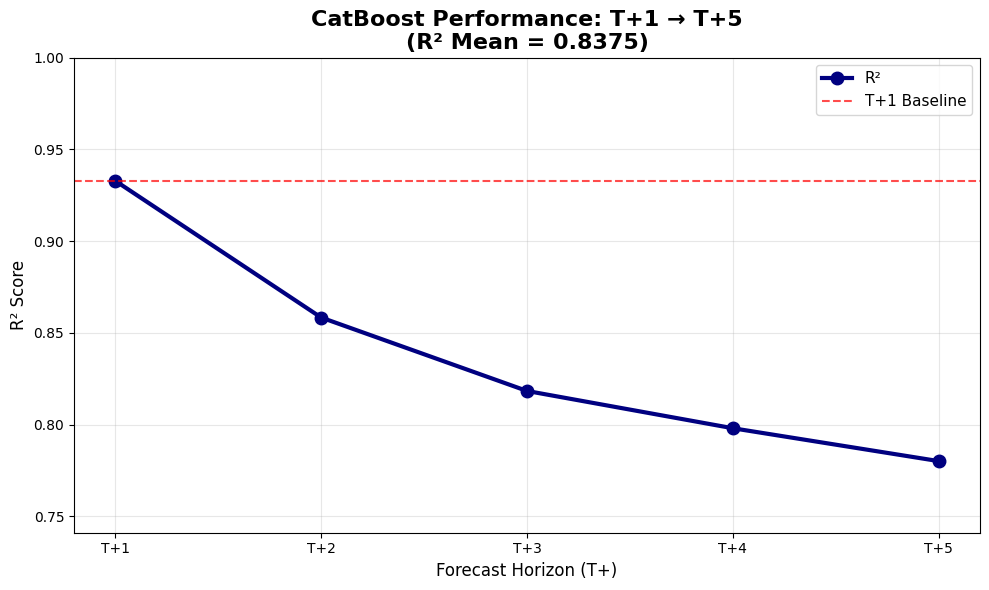

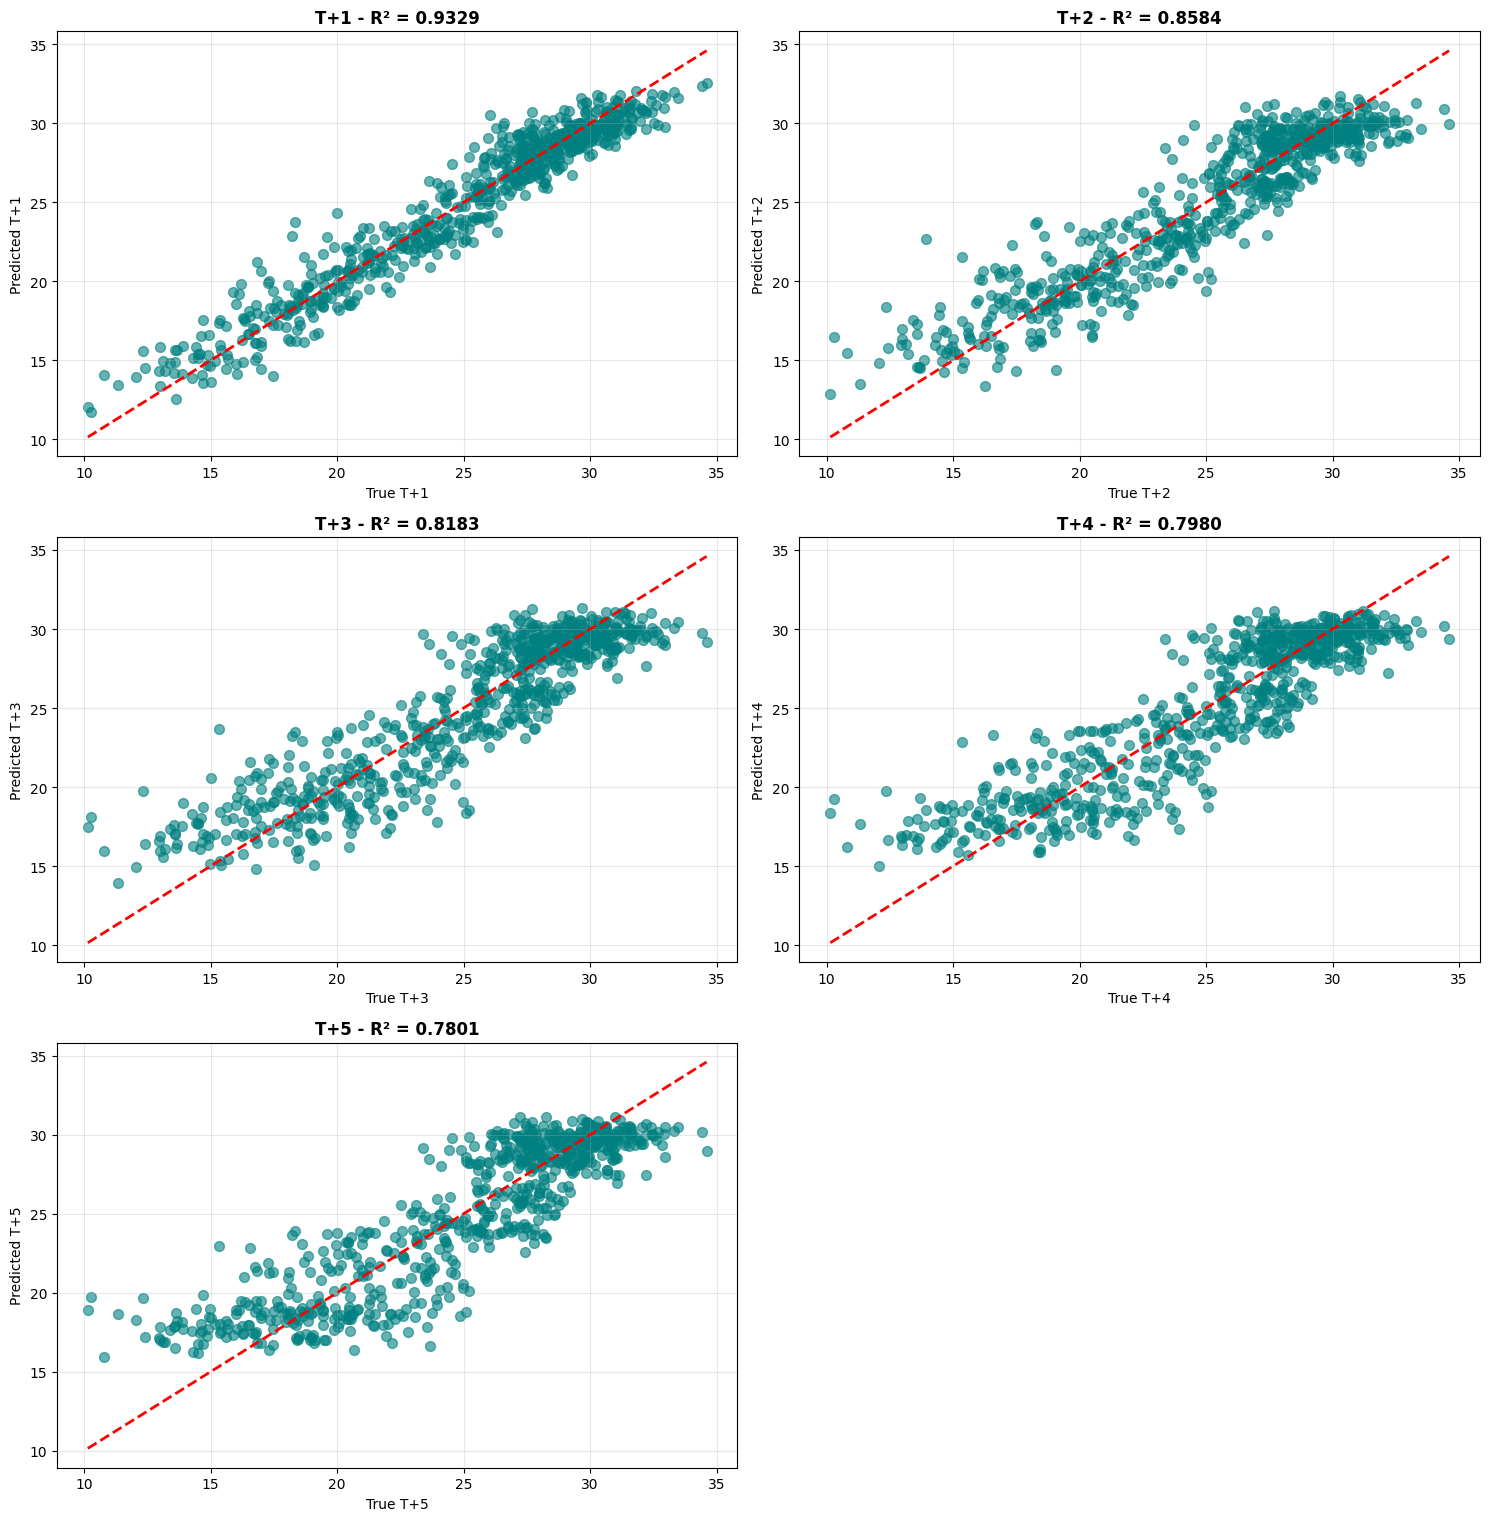


Đã lưu kết quả → catboost_single_result.csv


In [63]:
result = joblib.load('BEST_CATBOOST_TUNED.joblib')
best_params = result['best_params']  # từ tune_catboost_with_predefined_split()
model = result['model']

# Chạy với best_params
result2 = catboost_single_run(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    best_params=best_params,
    plot=True,
    verbose=True
)

### Final Model Training with Optimal Parameters

Load the best hyperparameters from tuning and train the final model with comprehensive evaluation and visualization.

**Expected Output:**
- Detailed performance metrics for each forecast horizon (T+1 to T+5)
- Degradation analysis showing how accuracy changes across forecast horizons
- Performance visualization charts
- Actual vs predicted scatter plots for model validation